In [2]:
import networkx as nx
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.colors as colors
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
# import random
# from random import sample
# from matplotlib.lines import Line2D
# import matplotlib.patches as patches
# from matplotlib.patches import Rectangle
# import seaborn as sns
# import matplotlib.image as mpimg

# from cProfile import label
# from mpl_toolkits.mplot3d import Axes3D
# from IPython.display import IFrame, display, Image

# np.set_printoptions(suppress=True)

In [62]:
import folium

In [ ]:
# from shapely.geometry import Point, MultiPoint
# from shapely.ops import nearest_points

In [3]:
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_17393/3210477311.py:2: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


'1.6.0'

# 1. Download and Load OpenStreetMap Street Network Data

In [13]:
# # Create a filter to query OSM for the specified network type.
# ox.downloader._get_osm_filter('drive')

In [49]:
# cf = '["highway"]["area"!~"yes"]["access"!~"private"]["highway"!~"abandoned|construction|planned|platform|proposed|raceway|service|path|steps|footway"]["service"!~"private"]'
cf = '["highway"]["area"!~"yes"]["access"!~"private"]["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|road"]'

In [50]:
# G = ox.graph_from_point(location_point, dist=300, dist_type="bbox", custom_filter=cf)
G = ox.graph_from_place('Overijssel', network_type='drive', custom_filter=cf)

In [51]:
G = ox.project_graph(G, to_crs="EPSG:3857")

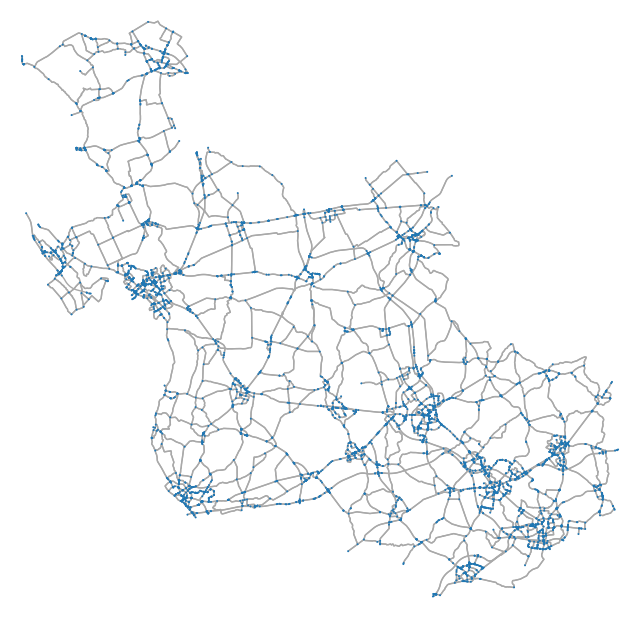

In [52]:
fig, ax = ox.plot_graph(G, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# n_ped.plot(ax=ax, markersize=45, zorder=5, c=colors)
# e_ped.plot(ax=ax, color='darkgray', linewidth=3, zorder=0)
# bgcolor= 'w', node_color='w', node_edgecolor='k', node_size=35, 
#                            node_zorder=3, edge_color=ec, edge_linewidth=3
# fig.savefig('./notebook_figures/G.eps',format='eps', dpi=1000,bbox_inches="tight")
# fig.savefig("./notebook_figures/G.png", format = 'png', dpi= 1000, bbox_inches="tight")

In [96]:
# consolidate intersection to further simplify the topography of the graph
G_base = ox.consolidate_intersections(G, tolerance=100, rebuild_graph=True, dead_ends=False)

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/osmnx/simplification.py:542: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8-0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, "cluster"] = f"{cluster_label}-{suffix}"


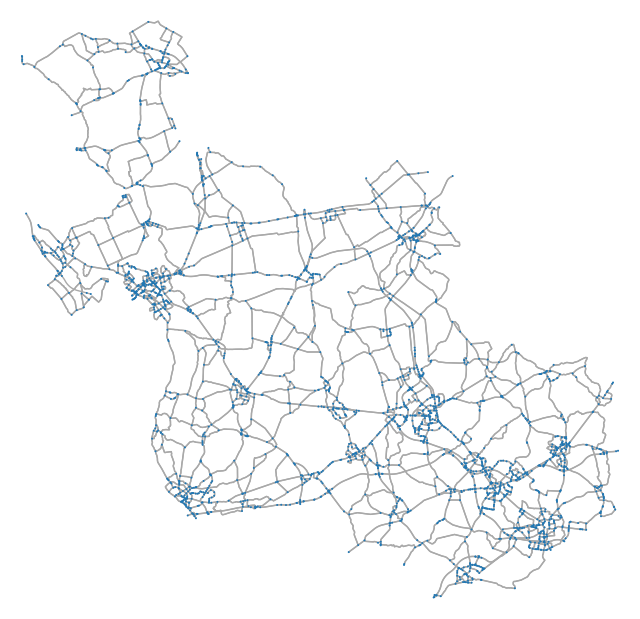

In [86]:
fig, ax = ox.plot_graph(G_base, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# fig.savefig('./notebook_figures/G_base.eps',format='eps', dpi=1000, bbox_inches="tight")
fig.savefig("./G_base.png", format = 'png', dpi= 1000, bbox_inches="tight") #transparent=True

In [97]:
print(len(G_base.nodes), len(G.nodes))

1972 5590


In [67]:
list(G_base.nodes(data=True))[0:3] # examine edges

[(0,
  {'osmid_original': 29092110,
   'y': 6863326.893917802,
   'x': 732329.1183282048,
   'street_count': 3,
   'lon': 6.5786244,
   'lat': 52.3481774}),
 (1,
  {'osmid_original': 1873507619,
   'y': 6862992.538656716,
   'x': 732029.3015436514,
   'street_count': 3,
   'lon': 6.5759311,
   'lat': 52.3463426}),
 (2,
  {'osmid_original': '[29092113, 247365707, 247365720]',
   'x': 732779.6746758356,
   'y': 6863747.104673857,
   'street_count': 0})]

In [68]:
list(G_base.edges(data=True))[0:1] # examine edges

[(0,
  1,
  {'osmid': 16313405,
   'lanes': '2',
   'ref': 'N350',
   'name': 'Rijssensestraat',
   'highway': 'primary',
   'maxspeed': '80',
   'oneway': False,
   'reversed': True,
   'length': 274.047,
   'geometry': <LINESTRING (732329.118 6863326.894, 732282.965 6863276.707, 732239.439 6863...>,
   'u_original': 29092110,
   'v_original': 1873507619})]

In [63]:
m = folium.Map(location=[52.36735155657406, 6.666501948287694], zoom_start=15)  # Set the initial map location and zoom level

In [ ]:
for node in G_base.nodes(data=True):
    lat = node[1]['lat']
    lon = node[1]['lon']

In [80]:
for node in G.nodes(data=True):
    node_id, node_data = node
    if 'lat' in node_data and 'lon' in node_data:
        lat = node_data['lat']
        lon = node_data['lon']
        folium.Marker(location=[lat, lon], icon=folium.Icon(color='blue')).add_to(m)

In [81]:
# Add edges to the Folium map using LineString geometry
for edge in G_base.edges(data=True):
    u, v, data = edge
    geometry = data['geometry']
    coordinates = list(geometry.coords)
    folium.PolyLine(coordinates, color='black').add_to(m)

In [83]:
m.save('networkx_map.html')

In [98]:
n, e = ox.graph_to_gdfs(G_base)

In [99]:
n["geometry"].to_file("./osm_network/G_base_nodes.shp")

In [100]:
# Convert lists to strings
e['highway'] = e['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [93]:
e['highway'].unique()

array(['primary', 'motorway_link', 'motorway', 'secondary', 'tertiary',
       'trunk', 'secondary, tertiary', 'trunk_link', 'trunk, motorway',
       'secondary_link', 'tertiary_link', 'primary_link',
       'motorway, primary', 'trunk, motorway_link', 'trunk, primary',
       'motorway_link, trunk_link', 'primary_link, tertiary',
       'trunk_link, primary', 'secondary, trunk_link',
       'motorway_link, primary'], dtype=object)

In [101]:
e[["geometry","highway"]].to_file("./osm_network/G_base_edges.shp")

In [17]:
dh = dh.to_crs(e.crs)

In [18]:
nl = gpd.read_file("./data/nl_administrative_boundary/st293bj4601.shp")
nl = nl.to_crs(e.crs)

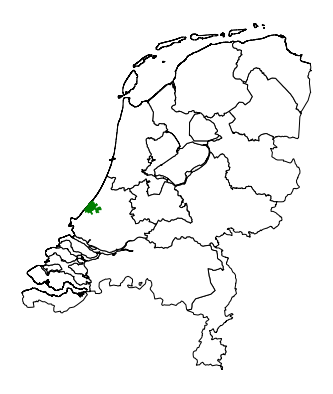

In [19]:
fig, ax = plt.subplots(figsize=(7,7)) # gridspec_kw={ 'width_ratios':[2,1]}) #gridspec_kw={'width_ratios': [1.45, 1]}
# e.plot(ax=ax1, color='black', linewidth=3, zorder=2)
dh.plot(ax=ax, facecolor='green', edgecolor='green', linewidth=0.5,  zorder=2)
nl.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=1,  zorder=1)
ax.set_axis_off()
# fig.savefig('./notebook_figures/toyproblem_nl_map.eps',format='eps', dpi=400, bbox_inches="tight", edgecolor='black')
# fig.savefig("./notebook_figures/toyproblem_nl_map.png", format = 'png', dpi= 500, bbox_inches="tight", edgecolor='black') #transparent=True

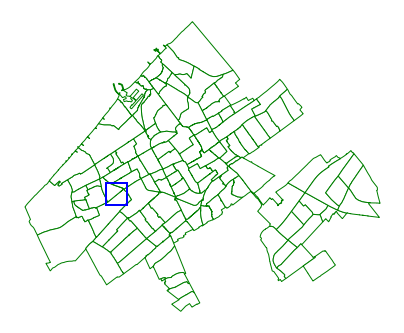

In [20]:
fig, ax = plt.subplots(figsize=(7,7)) # gridspec_kw={ 'width_ratios':[2,1]}) #gridspec_kw={'width_ratios': [1.45, 1]}
# e.plot(ax=ax1, color='black', linewidth=3, zorder=2)
dh.plot(ax=ax, facecolor='white', edgecolor='green', linewidth=1,  zorder=1)
ax.add_patch(Rectangle((472890.663600, 6810379.841), 1500, 1500,
             edgecolor = 'blue', #facecolor = 'blue',
             fill=False,
             lw=2))
ax.set_axis_off()
# fig.savefig('./notebook_figures/toyproblem_den_haag_map.eps',format='eps', dpi=500, bbox_inches="tight", edgecolor='black')
# fig.savefig("./notebook_figures/toyproblem_den_haag_map.png", format = 'png', dpi= 500, bbox_inches="tight", edgecolor='black') #transparent=True

In [21]:
# Getting the all unique values in highway key
unique_highway = []
for item in e['highway']:
    if item not in unique_highway:
        unique_highway.append(item)
unique_highway

['living_street',
 'residential',
 'cycleway',
 'secondary',
 ['residential', 'living_street'],
 'tertiary']

In [22]:
list(G_base.edges(data=True))[0:3] # examine edges

[(0,
  1,
  {'osmid': 268017761,
   'name': 'Laan van Vredestein',
   'highway': 'living_street',
   'maxspeed': '15',
   'oneway': False,
   'length': 56.716,
   'geometry': <shapely.geometry.linestring.LineString at 0x16495a6e0>,
   'u_original': 45059031,
   'v_original': 45061282}),
 (1,
  10,
  {'osmid': 268017761,
   'name': 'Laan van Vredestein',
   'highway': 'living_street',
   'maxspeed': '15',
   'oneway': False,
   'length': 66.381,
   'geometry': <shapely.geometry.linestring.LineString at 0x164959150>,
   'u_original': 45061282,
   'v_original': 45063146}),
 (1,
  5,
  {'osmid': 7491625,
   'name': 'Laan van Vredestein',
   'highway': 'living_street',
   'maxspeed': '15',
   'oneway': False,
   'length': 54.233999999999995,
   'geometry': <shapely.geometry.linestring.LineString at 0x16495a5c0>,
   'u_original': 45061282,
   'v_original': 45060356})]

# 2. Classify street segments and build sub-graphs

#### 2.1 Import csv file of street segement classification table and create a list for drivable, bikable, walkable key values.

In [23]:
# Read the classification table into a DataFrame
classification = pd.read_csv("./data/Classify street segments.csv")

In [24]:
classification

,Key value,Car,Bike,Pedestrian
0,unclassified,1,1,1
1,cycleway,0,1,0
2,tertiary,1,1,1
3,residential,1,1,1
4,secondary,1,1,1
5,pedestrian,0,1,1
6,primary,1,1,1
7,living_street,1,1,1
8,motorway,1,0,0
9,motorway_link,1,0,0


In [25]:
def create_subgraph_edge_list(G_base, classification, transport_mode, assigned_score):

    """
    A function to extract the osm key values corresponding to different transport mode based on the classification system.

    Input:

    Output:

    """
    # extrac key values of edges that are accessible to the transport mode
    key_values = classification.loc[classification[transport_mode] == assigned_score, ['Key value']].to_numpy().tolist()
    
    # flattened the nested list
    key_values = [num for sublist in key_values for num in sublist]

    # empty list to store the 
    subgraph_edge_list = []
    for u, v, k in G_base.edges:
        if any(x in G_base.edges[u, v, k]['highway'] for x in key_values):
            subgraph_edge_list.append([u, v, k])
        # else:
        #     print('false')
    
    subgraph_edge_list = [tuple(l) for l in subgraph_edge_list]
    
    return subgraph_edge_list

In [26]:
bikeable_edges = create_subgraph_edge_list(G_base, classification, 'Bike', 1)
walkable_edges = create_subgraph_edge_list(G_base, classification, 'Pedestrian', 1)
driveable_edges = create_subgraph_edge_list(G_base, classification, 'Car', 1)

#### 2.2 Create subgraphs

In [27]:
G_start_ped = G_base.edge_subgraph(walkable_edges)

In [28]:
list(G_start_ped.edges(data=True))[0:1]

[(0,
  1,
  {'osmid': 268017761,
   'name': 'Laan van Vredestein',
   'highway': 'living_street',
   'maxspeed': '15',
   'oneway': False,
   'length': 56.716,
   'geometry': <shapely.geometry.linestring.LineString at 0x16495a6e0>,
   'u_original': 45059031,
   'v_original': 45061282})]

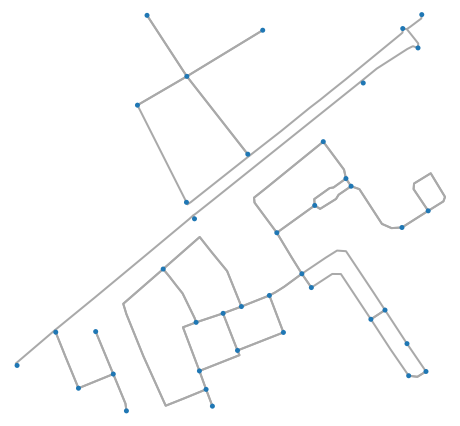

In [29]:
fig, ax = ox.plot_graph(G_start_ped, node_size=25, node_color='tab:blue', edge_linewidth=2, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# fig.savefig('./notebook_figures/G_start_ped.eps',format='eps', dpi=800, bbox_inches="tight")
# fig.savefig("./notebook_figures/G_start_ped.png", format = 'png', dpi= 800, bbox_inches="tight") #transparent=True

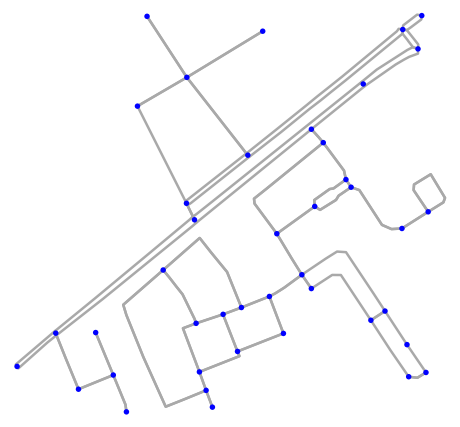

In [30]:
G_start_bike = G_base.edge_subgraph(bikeable_edges)
fig, ax = ox.plot_graph(G_start_bike, node_size=30, node_color='blue', edge_linewidth=2.5, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# fig.savefig('./notebook_figures/G_start_bike.eps',format='eps', dpi=800, bbox_inches="tight")
# fig.savefig("./notebook_figures/G_start_bike.png", format = 'png', dpi= 800, bbox_inches="tight") #transparent=True

# 2. Get all necessary edge attributes

#### 2.1 Weight of edges 

In [31]:
l_base = nx.get_edge_attributes(G_base,'length')
l_base

{(0, 1, 0): 56.716,
 (1, 10, 0): 66.381,
 (1, 5, 0): 54.233999999999995,
 (1, 0, 0): 56.716,
 (2, 3, 0): 25.884,
 (3, 7, 0): 28.307,
 (3, 2, 0): 25.884,
 (3, 8, 0): 298.746,
 (4, 9, 0): 27.249000000000002,
 (5, 6, 0): 142.14316419256699,
 (5, 1, 0): 54.233999999999995,
 (6, 5, 0): 142.14316419256699,
 (6, 16, 0): 434.45734402383715,
 (6, 16, 1): 434.7348642128213,
 (7, 3, 0): 28.307,
 (7, 11, 0): 87.578,
 (7, 12, 0): 69.464,
 (8, 11, 0): 91.115,
 (8, 3, 0): 298.74600000000004,
 (8, 20, 0): 188.407,
 (9, 13, 0): 48.638,
 (9, 4, 0): 27.249000000000002,
 (10, 1, 0): 66.381,
 (11, 15, 0): 41.1,
 (11, 8, 0): 91.115,
 (11, 7, 0): 87.578,
 (12, 14, 0): 71.174,
 (12, 15, 0): 57.449000000000005,
 (12, 7, 0): 69.464,
 (13, 18, 0): 57.923,
 (14, 19, 0): 57.078,
 (14, 12, 0): 71.174,
 (15, 20, 0): 28.196,
 (15, 11, 0): 41.1,
 (15, 12, 0): 57.449000000000005,
 (16, 30, 0): 357.48699237037175,
 (16, 40, 0): 43.090661573761196,
 (16, 39, 0): 521.757597287239,
 (17, 18, 0): 24.33,
 (17, 4, 0): 98.03,


In [32]:
l_base_new = {i[:-1]:l_base[i] for i in l_base} # get rid of the parallel edges 

In [33]:
print(len(l_base_new), len(G_base.edges)) # 

89 97


In [34]:
l_base_df = pd.DataFrame.from_dict(l_base_new, orient='index', columns=['length']).reset_index().rename(columns={"index": "edge_key"})
l_base_df

,edge_key,length
0,"(0, 1)",56.716000
1,"(1, 10)",66.381000
2,"(1, 5)",54.234000
3,"(1, 0)",56.716000
4,"(2, 3)",25.884000
...,...,...
84,"(38, 36)",61.039415
85,"(39, 37)",164.540925
86,"(40, 16)",43.090662
87,"(40, 31)",255.732158


# 3. Get all necessary node attributes

#### 3.1 POI
Each node should have attributes that inform the types (and number?) of POI it has. 

In [35]:
def create_poi_gdf(city, crs):
    
    '''
    Downloads public transport, parks, and urban amenities from OpenStreetMap, classifies them into seven distinct categories, and
    outputs a point geodataframe
    '''
    
    # ##public transport
    # #get public transport (rail) network of metro vancouver
    # rail = ox.graph_from_polygon(MAREA.iloc[0,0], network_type='all',
    #                               infrastructure='way["railway"]', retain_all=True)
    # #make rail pois
    # rail_gdf = ox.save_load.graph_to_gdfs(rail, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
    # rail_gdf['amenity'] = 'transit_stop'
    # rail_gdf = rail_gdf[['amenity', 'geometry']]

    # #get public bus stops
    # bus = ox.footprints.footprints_from_polygon(polygon = MAREA.iloc[0,0], footprint_type = 'public_transport')
    # bus['amenity'] = 'public_transport'
    # bus['centroid'] = bus.centroid
    # bus = bus.set_geometry('centroid')
    # bus = bus[['amenity', 'centroid']]
    # bus = bus.rename(columns = {"centroid": "geometry"})

    ##amenities pois
    # define your selected amenities 
        # "transit_stop", "bus_station", "bus_stop",
    amenity_tag = {'amenity': [
        "pub", "bar", "theatre", "cinema", "events_venue", "arts_centre", #recreation
        "restaurant", "cafe", "food_court", "marketplace", #food_choices
        "community_centre", "library", "social_facility", "social_centre", "townhall", #community_space
        "school", "childcare", "kindergarten", "university", "college", #education
        "pharmacy", "dentist", "clinic", "hospital", "doctors", "bank", "police"]} #health_wellbeing

    #request amenities from the OpenStreetMap API (Overpass)
    pois = ox.geometries_from_point(city, amenity_tag, dist=300) #THIS PART NEEDS TO BE CHANGED LATER!!!!!!!!
    # pois = ox.pois_from_polygon(MAREA.iloc[0,0])
    pois = pois.to_crs(crs)
    pois['centroid'] = pois.centroid
    pois = pois.set_geometry('centroid')
    #pois = pois[pois['amenity'].isin(amenities)]
    pois = pois[['amenity','centroid']]
    pois = pois.rename(columns = {"centroid": "geometry"})
    pois = pois.reset_index(level='element_type', drop=True)

    #get parks and "leisure" elements
    leisure_tag = {'leisure':["fitness_centre", "sports_centre", "park", "pitch", "playground", "swimming_pool", "garden", 
                "nature_reserve", "marina", "recreation_ground", "fitness_station", "skate_park"]}

    #parks = ox.footprints.footprints_from_polygon(polygon = MAREA.iloc[0,0], footprint_type = 'leisure')
    parks = ox.geometries_from_point(city, leisure_tag, dist=300) #THIS PART NEEDS TO BE CHANGED LATER!!!!!!!!!!!
    #parks = parks[parks['leisure'].isin(leisure)]
    parks = parks.to_crs(crs)
    parks['centroid'] = parks.centroid
    parks = parks.set_geometry('centroid')
    parks = parks[['leisure','centroid']]
    parks = parks.rename(columns = {"leisure":"amenity","centroid": "geometry"})
    parks = parks.reset_index(level='element_type', drop=True)

    #merge all the dataframes together
    #merge dataframes together
    pois_list = [pois, parks] #(exclude rail_gdf, bus)
    pois_all = pd.concat(pois_list, axis=0, ignore_index=True)

    #create x and y columns for network analysis
    pois_all['x'] = pois_all.centroid.x
    pois_all['y'] = pois_all.centroid.y
    
    pois_all['centroid'] = pois_all.centroid
    pois_all = pois_all.set_geometry('centroid')
    pois_all = pois_all[['amenity', 'x', 'y','centroid']]
    pois_all = pois_all.rename(columns = {"centroid": "geometry"})
    pois_all = pois_all.set_geometry('geometry')
    
    return pois_all

In [36]:
pois_all = create_poi_gdf(location_point, "EPSG:3857")
pois_all

,amenity,x,y,geometry
0,hospital,473180.764265,6.811101e+06,POINT (473180.764 6811100.587)
1,school,473760.969435,6.810568e+06,POINT (473760.969 6810567.548)
2,playground,473929.273526,6.810682e+06,POINT (473929.274 6810682.350)
3,playground,473908.256406,6.810630e+06,POINT (473908.256 6810630.245)
4,park,474202.571841,6.811093e+06,POINT (474202.572 6811092.854)
5,pitch,473902.288627,6.810589e+06,POINT (473902.289 6810588.669)
6,pitch,473955.383351,6.810614e+06,POINT (473955.383 6810614.334)
7,park,473961.217440,6.811080e+06,POINT (473961.217 6811079.675)
8,park,473975.779506,6.810480e+06,POINT (473975.780 6810479.977)


In [37]:
n_ped, e_ped = ox.graph_to_gdfs(G_start_ped)

In [38]:
def categorize_amenities(pois_all):
    '''
    Aggregates amenities into seven distinct categories.
    

    Output:
        p       Dataframe with names of POIs changed to the category they're in.
        P_df    Dataframe with categories as columns, assigning each POI to a category with binary value 1. 
        P       Numpy array of P_df
    '''
    
    # reshape dataframe
#     pois_all = pd.melt(pois_df, id_vars=['osmid', 'geometry', 'x', 'y'], var_name='amenity')
    # define categories
    # mobility = ["transit_stop", "bus_station", "bus_stop", "public_transport"]
    
    active_living = ["fitness_centre", "sports_centre", "park", "pitch", "playground", "swimming_pool", "garden", "nature_reserve", "marina", 
                     "recreation_ground", "fitness_station", "skate_park"] 

    recreation = ["pub", "bar", "theatre", "cinema", "events_venue", "arts_centre"]

    food_choices = ["restaurant", "cafe", "food_court", "marketplace"]

    community_space = ["community_centre", "library", "social_facility", "social_centre", "townhall"]

    education = ["school", "childcare", "kindergarten", "university", "college"]

    health_wellbeing = ["pharmacy", "dentist", "clinic", "hospital", "doctors", "bank", "police"]

    cat_list = [active_living, recreation, food_choices, community_space, education, health_wellbeing]
    cat_list_str = ["active_living", "recreation", "food_choices", "community_space", "education", "health_wellbeing"]

    for cat in cat_list:
        cat_index = cat_list.index(cat) #The index() method returns the index of the specified element in the list.
        #pois_all.amenity[pois_all['amenity'].isin(cat)] = cat_list_str[cat_index]
        pois_all.loc[pois_all.amenity.isin(cat), 'amenity'] = cat_list_str[cat_index] 
                            #if amenity matches any of the elements in 'cat' (nested list of one of the category)
                            #then give it the string value with the same index in cat_list_str

    # Convert pois_all_df to the matrix P 
    # P := [P_v]_(o x k)
    P_df = pd.get_dummies(pois_all.amenity)
    P = P_df.to_numpy()  #add .np later!!!!!!
    
    return pois_all, P_df, P

In [39]:
# One of the main differences between views and copies is that modifying a view modifies the original dataframe and vice versa, whereas modifying a copy doesn’t affect the original dataframe.
# pois_all.amenity[pois_all['amenity'].isin(cat)]._is_copy

In [40]:
p, P_df, P = categorize_amenities(pois_all)

In [41]:
p

,amenity,x,y,geometry
0,health_wellbeing,473180.764265,6.811101e+06,POINT (473180.764 6811100.587)
1,education,473760.969435,6.810568e+06,POINT (473760.969 6810567.548)
2,active_living,473929.273526,6.810682e+06,POINT (473929.274 6810682.350)
3,active_living,473908.256406,6.810630e+06,POINT (473908.256 6810630.245)
4,active_living,474202.571841,6.811093e+06,POINT (474202.572 6811092.854)
5,active_living,473902.288627,6.810589e+06,POINT (473902.289 6810588.669)
6,active_living,473955.383351,6.810614e+06,POINT (473955.383 6810614.334)
7,active_living,473961.217440,6.811080e+06,POINT (473961.217 6811079.675)
8,active_living,473975.779506,6.810480e+06,POINT (473975.780 6810479.977)


In [42]:
P

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [43]:
# matrix = pois_all_cat.iloc[:,0].str.split(', ', expand=True).stack().reset_index(drop=True).str.get_dummies()
# print(matrix)

In [44]:
# https://autogis-site.readthedocs.io/en/latest/notebooks/L3/04_nearest-neighbour.html
def get_nearest_node_to_poi(row, node_gdf, point_column='geometry', value_column='geometry'):

    # Create an union of the node GeoDataFrame's geometries
    node = node_gdf['geometry'].unary_union

    # Find the nearest node to each poi 
    nearest_geoms = nearest_points(row[point_column], node)

    # Get corresponding values from the node df 
    nearest_node = node_gdf.loc[node_gdf['geometry'] == nearest_geoms[1]] 
    nearest_value = nearest_node.index.values[0] # might need to change value_column to osmid 
    #nearest_value = nearest_node[value_column].values[0] # might need to change value_column to osmid 

    return nearest_value 

In [45]:
p['nearest_node'] = p.apply(get_nearest_node_to_poi, node_gdf = n, point_column='geometry', value_column=['geometry'],  axis=1)
p

,amenity,x,y,geometry,nearest_node
0,health_wellbeing,473180.764265,6.811101e+06,POINT (473180.764 6811100.587),6
1,education,473760.969435,6.810568e+06,POINT (473760.969 6810567.548),2
2,active_living,473929.273526,6.810682e+06,POINT (473929.274 6810682.350),14
3,active_living,473908.256406,6.810630e+06,POINT (473908.256 6810630.245),14
4,active_living,474202.571841,6.811093e+06,POINT (474202.572 6811092.854),28
5,active_living,473902.288627,6.810589e+06,POINT (473902.289 6810588.669),14
6,active_living,473955.383351,6.810614e+06,POINT (473955.383 6810614.334),14
7,active_living,473961.217440,6.811080e+06,POINT (473961.217 6811079.675),25
8,active_living,473975.779506,6.810480e+06,POINT (473975.780 6810479.977),4


In [46]:
color_dict = {'health_wellbeing':'tab:red','education':'tab:orange', 'active_living':'tab:green'}

In [47]:
p.amenity.unique()

array(['health_wellbeing', 'education', 'active_living'], dtype=object)

In [48]:
# p.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/networks/poi_G_base.csv')
p[['amenity','geometry']].to_file("./networks/G_poi.shp")

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other

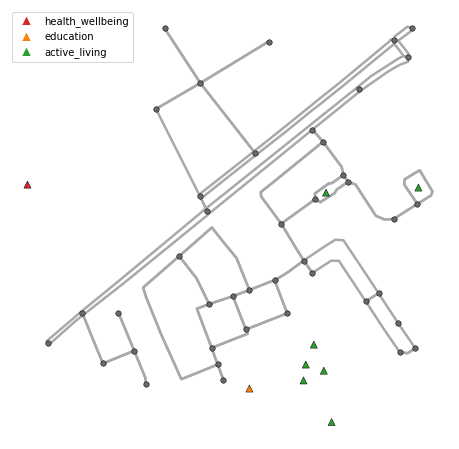

In [49]:
fig, ax = plt.subplots(1, figsize=(8,8))
p.plot(ax=ax, marker='^', markersize=50, linewidth= 0.5, edgecolor='black', zorder=10, c = p['amenity'].map(color_dict))
n.plot(ax=ax, color='dimgray', linewidth= 0.5, edgecolor='black', markersize=30, zorder=5)
e.plot(ax=ax, color='darkgray', linewidth=2.5, zorder=0)
# for txt, lat, lon in zip(n.index, n.x, n.y):
#     ax.annotate(txt, (lat, lon),
#                 # horizontalalignment="center",
#                 # verticalalignment="bottom" if lon > 0 else "top"
#                 ) #,ha='center'
# add a legend
handles = [Line2D([0], [0], marker='^', color='w', markerfacecolor=v, label=k, markersize=10) for k, v in color_dict.items()]
ax.legend(handles=handles) #, bbox_to_anchor=(1.05, 1), loc='upper left')


# sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=n.s_final.max(), vmax=n.s_final.min()))
# sm._A = []
# cbar = fig.colorbar(sm, shrink=0.5)

ax.set_axis_off()
plt.show()
# fig.savefig('./notebook_figures/poi_map.eps',format='eps', dpi=800,bbox_inches="tight")
# fig.savefig("./notebook_figures/poi_map.png", format = 'png', dpi= 800, bbox_inches="tight")


In [50]:
# Generate colors for plotting
def color_plot_generation(t):
    if t in n_active_living:
        return "tab:green"
    elif t in n_education:
        return "tab:orange"
    elif t in n_health_wellbeing:
        return "tab:red"
    return 'dimgray'

In [51]:
# colors= [color_plot_generation(i) for i in n.index.values]

In [52]:
# color_dict = {'active_living_vertex': 'tab:green', 'education_vertex':'tab:orange', 'health_wellbeing_vertex':'tab:red', 'non-poi_vertex':'dimgray'}

In [53]:
# fig, ax = plt.subplots(1, figsize=(8,8))
# n.plot(ax=ax, color=colors, linewidth= 0.5, markersize=40, zorder=5)
# e.plot(ax=ax, color='darkgray', linewidth=2.5, zorder=0)

# # for txt, lat, lon in zip(n_ped.index, n_ped.x, n_ped.y):
# #     ax.annotate(txt, (lat, lon),
# #                 # horizontalalignment="center",
# #                 # verticalalignment="bottom" if lon > 0 else "top"
# #                 ) #,ha='center'

# custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
# leg_points = ax.legend(custom_points, color_dict.keys(),loc='upper left')
# ax.add_artist(leg_points)

# ax.set_axis_off()
# plt.show()
# fig.savefig('./notebook_figures/poi_to_vertex_map.eps',format='eps', dpi=800,bbox_inches="tight")
# fig.savefig("./notebook_figures/poi_to_vertex_map.png", format = 'png', dpi= 800, bbox_inches="tight")

In [54]:
# Transform data to matrix C after nearest neighbor is computed 
n_copy = n.copy()
# 1. groupby the node's index ("nearest_node") as key and amenity index as key values
p_dict = {k: list(v) for k,v in p.reset_index().groupby("nearest_node")["index"]}
# print(p_dict)

# 2. remove duplicate values by using set(), make sure key value is tuple not list 
    # p_dict = {key: tuple(set(value)) for key, value in p_dict.items()} # https://stackoverflow.com/questions/20112760/python-pandas-convert-dataframe-to-dictionary-with-multiple-values

# 3. add the dictionary as a column of the node DataFrame
n_copy['poi'] = n_copy.index.map(p_dict)
# print(n_copy)

# 4. transform the DataFrame into matrix - convert categorical variable into dummy/indicator variables
C_df = n_copy['poi'].str.get_dummies(sep=',') 

# 5. DataFrame needs to be further formated before converting to a matrix
C_df.columns = C_df.columns.str.strip("[]").astype("int") #format column title to get rid of the []
C_columns_list = list(range(0, len(C_df.columns), 1)) #create a list to sort the column from 0 ascending to the last poi
#my_list = [str(x) for x in my_list] 
# print(C_columns_list)
C_df = C_df[C_columns_list]
C = C_df.to_numpy()
C

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0,

In [55]:
C.shape

(42, 9)

In [56]:
P.shape

(9, 3)

In [57]:
P_final = np.dot(C , P)

In [58]:
P_final

array([[0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [4, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

Note: Values larger than 1 will appear in P' matrix (P_final) if a node is assigned more than 1 POI of the same category:

#### 3.2 Vulnerability score

In [59]:
n["geometry"].to_file("./networks/G_nodes.shp")

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


In [60]:
e["geometry"].to_file("./networks/G_edges.shp")

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


In [61]:
# Load in disadvantage_grid.csv that was exported from QGIS
# This csv contains a table with all spatial units (area_id) and their corresponding vulnerability score (n_vul)
v_df = pd.read_csv("./transformed_data/disadvantage_grid.csv", index_col = "area_id") #note that this file was still in EPSG: 28992
v_df

,DN,area,neighb_cbs,neigb_cijf,avg_income,Disadvanta,% private,vul_index,n_disad,n_pop,n_vul
area_id,,,,,,,,,,,
1,0,47865,Oostduinen,70 Oostduinen,NaN,NaN,NaN,NaN,NaN,0.000,NaN
2,0,47609,Oostduinen,70 Oostduinen,NaN,NaN,NaN,NaN,NaN,0.000,NaN
3,4,47629,Oostduinen,70 Oostduinen,NaN,NaN,NaN,NaN,NaN,0.010,NaN
4,41,47629,Oostduinen,70 Oostduinen,NaN,NaN,NaN,NaN,NaN,0.099,NaN
5,50,47629,Oostduinen,70 Oostduinen,NaN,NaN,NaN,NaN,NaN,0.120,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1784,0,48129,Ockenburgh,90 Ockenburgh,97700.0,-16.9,0.297,0.0,0.193,0.000,0.000
1785,39,47700,Ockenburgh,90 Ockenburgh,97700.0,-16.9,0.297,0.0,0.193,0.094,0.009
1786,13,47506,Ockenburgh,90 Ockenburgh,97700.0,-16.9,0.297,0.0,0.193,0.031,0.003


In [62]:
# Load in B.csv that was exported from QGIS
# This is a table that assigns a spatial unit to every node 
B_df = pd.read_csv("./transformed_data/B_toymodel.csv", index_col = "osmid" ) #note that this file was still in EPSG: 28992

# Create matrix B
B = pd.get_dummies(B_df.area_id)
B

,851,922,923,924,997,998,999,1066,1758
osmid,,,,,,,,,
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1
5,0,0,0,0,1,0,0,0,0
6,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,1,0,0,0


In [63]:
# Only for toy problem: get only the 24 spatial units in this toy problem that the nodes appear in

# Getting the all unique id of spatial units in B DataFrame
spatial_unit_id = []
for item in B_df['area_id']:
    if item not in spatial_unit_id:
        spatial_unit_id.append(item)
v_df = v_df[v_df.index.isin(spatial_unit_id)]
v_df

,DN,area,neighb_cbs,neigb_cijf,avg_income,Disadvanta,% private,vul_index,n_disad,n_pop,n_vul
area_id,,,,,,,,,,,
851,388,47692,Eykenduinen,83 Eykenduynen,45100.0,-10.6,0.502,0.009,0.341,0.933,0.159
922,404,47695,Rosenburg,82 Rosenburg,35000.0,-1.3,0.358,0.012,0.560,0.971,0.272
923,411,47695,Rosenburg,82 Rosenburg,35000.0,-1.3,0.358,0.012,0.560,0.988,0.277
924,410,47695,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.009,0.449,0.986,0.221
997,318,47698,Rosenburg,82 Rosenburg,35000.0,-1.3,0.358,0.009,0.560,0.764,0.214
998,362,47698,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.008,0.449,0.870,0.195
999,364,47867,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.008,0.449,0.875,0.196
1066,413,47700,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.009,0.449,0.993,0.223
1758,364,47528,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.008,0.449,0.875,0.196


In [64]:
# Create vector s
v = v_df[["n_vul"]].to_numpy()
v

array([[0.159],
       [0.272],
       [0.277],
       [0.221],
       [0.214],
       [0.195],
       [0.196],
       [0.223],
       [0.196]])

In [65]:
# Direct extraction of vector s' from B.csv - not in a way formulated in data transformation
# s_final_old = B_df[['n_vul']].to_numpy()
# s_final_old

In [66]:
B.shape

(42, 9)

In [67]:
v.shape

(9, 1)

In [68]:
# Create vector s'
v_final = np.dot(B, v)
v_final

array([[0.223],
       [0.195],
       [0.223],
       [0.195],
       [0.196],
       [0.214],
       [0.214],
       [0.195],
       [0.195],
       [0.196],
       [0.214],
       [0.195],
       [0.196],
       [0.196],
       [0.196],
       [0.196],
       [0.195],
       [0.196],
       [0.196],
       [0.196],
       [0.196],
       [0.196],
       [0.196],
       [0.196],
       [0.277],
       [0.277],
       [0.196],
       [0.221],
       [0.196],
       [0.221],
       [0.277],
       [0.272],
       [0.272],
       [0.277],
       [0.272],
       [0.277],
       [0.221],
       [0.221],
       [0.159],
       [0.221],
       [0.272],
       [0.214]])

In [69]:
v_final.shape

(42, 1)

In [70]:
n['v_final']=pd.Series(v_final.flatten())

In [71]:
# n.s_final.unique()

In [72]:
# https://waldyrious.net/viridis-palette-generator/
color_dict=  {0.159: '#f0f921', 
                0.195: '#febd2a',
                0.196: '#f48849',
                0.214: '#db5c68',
                0.221: '#b83289',
                0.223: '#8b0aa5',
                0.272: '#5302a3',
                0.277: '#0d0887'}

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other

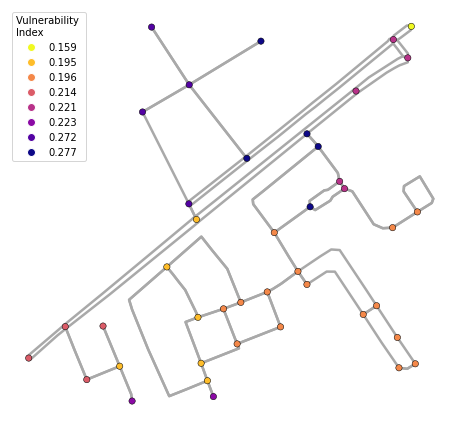

In [73]:
fig, ax = plt.subplots(1, figsize=(8,8))
e.plot(ax=ax, color='darkgray', linewidth=2.5, zorder=0)
n.plot(ax=ax, markersize=40, zorder=5, linewidth=0.5, edgecolor='black',  c=n['v_final'].map(color_dict))#c=n['s_final'], cmap='Blues')

# for txt, lat, lon in zip(n.index, n.x, n.y):
#     ax.annotate(txt, (lat, lon),
#                 # horizontalalignment="center",
#                 # verticalalignment="bottom" if lon > 0 else "top"
#                 ) #,ha='center'

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color_dict.items()]
ax.legend(title='Vulnerability \nIndex', handles=handles) #, bbox_to_anchor=(1.05, 1), loc='upper left')


# sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=n.s_final.max(), vmax=n.s_final.min()))
# sm._A = []
# cbar = fig.colorbar(sm, shrink=0.5)

ax.set_axis_off()
plt.show()
# fig.savefig('./notebook_figures/s_map.eps',format='eps', dpi=800,bbox_inches="tight")
# fig.savefig("./notebook_figures/s_map.png", format = 'png', dpi= 800, bbox_inches="tight")

# 4. Model formulation

In [74]:
def get_decision_variable(G_base, G_start, l_base):
    
    # Get a list of edges that are in base graph but not the subgraph for a transport mode
    edges_not_in_G_start = list(set([x[:-1] for x in list(G_base.edges)]).difference([x[:-1] for x in list(G_start.edges)])) #pedestrian network
    
    # Get the dimension of the decision variable
    m_design = len(edges_not_in_G_start)

    # Create vector l (length) for the decision variable
    # Get the l of edges that are in the list of edges_not_in_G_start from the length DataFrame of base graph
    l_x_df = l_base[l_base['edge_key'].isin(edges_not_in_G_start)].set_index('edge_key').reindex(edges_not_in_G_start)
    # Convert the length DataFrame to an array
    l_x = np.array(l_x_df)

    return  edges_not_in_G_start, m_design, l_x

In [75]:
edges_not_in_G_start_ped, m_design, l_x = get_decision_variable(G_base, G_start_ped, l_base_df)

In [76]:
edges_not_in_G_start_ped

[(30, 24), (24, 30), (40, 16), (30, 39), (16, 40), (16, 30)]

In [77]:
l_x

array([[ 25.86      ],
       [ 25.86      ],
       [ 43.09066157],
       [167.57648354],
       [ 43.09066157],
       [357.48699237]])

In [78]:
print("G_base")
print("Without parallel edges:", len(set([x[:-1] for x in list(G_base.edges)])))
print("With parallel edges:", len(set([x for x in list(G_base.edges)])))

G_base
Without parallel edges: 89
With parallel edges: 97


In [79]:
print("G_start_ped")
print("Without parallel edges:", len(set([x[:-1] for x in list(G_start_ped.edges)])))
print("With parallel edges:", len(set([x for x in list(G_start_ped.edges)])))

G_start_ped
Without parallel edges: 83
With parallel edges: 84


#### 4.1 Calculating initial accessibility

Taking pedestrian network as example:

In [80]:
P_df

,active_living,education,health_wellbeing
0,0,0,1
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0
6,1,0,0
7,1,0,0
8,1,0,0


#### Here manual checking of the P_df is required to see which categories of POI are in the study area. 

In [81]:
# Get the ID of vertices in every poi category from P_final matrix 
# order of poi categories can be checked at P_df: 
# 
# toy problem: active_living     education	health_wellbeing

n_active_living = tuple(x for i in np.where((P_final[:,0]) > 0) for x in i)
n_education = tuple(x for i in np.where((P_final[:,1]) > 0) for x in i)
#n_food_choices = tuple(x for i in np.where((P_final[:,2]) > 0) for x in i)
n_health_wellbeing = tuple(x for i in np.where((P_final[:,2]) > 0) for x in i)

# {k: list(v) for k,v in p.reset_index().groupby("nearest_node")["index"]}

In [82]:
all_poi_nodes_index = [n_active_living, n_education, n_health_wellbeing]
all_poi_nodes_index

[(4, 14, 25, 28), (2,), (6,)]

So there's the problem of:
1. Node (6) not found in graph - when a node is not in the sub graph atm
2. Node (27, 33, 64) not found in graph - when there are more than 1 element in the tuple. perhaps need for loop....

By creating a D_k_df in the dimension of nx1, we make sure that even if a subgraph has less nodes than base graph, we will have a D with the dimension of nx1. Now the problem is what to do with nan values. 

In [83]:
# Version with filling in NaN values
def calculate_accessibility(G, all_poi_nodes_index_list):
    
    D = np.zeros(len(n.index))

    for single_node_index_list in all_poi_nodes_index_list:
        D_k_df = pd.DataFrame(index=n.index) # D_k := [D]_n x o_k
        
        for o_k in single_node_index_list:
            
            # check if destination node is present in the subgraph - dijstra can't run if the node is absent
            if G.has_node(o_k):
            
            # potential problem - skip if there's no path 
                # calculate shortest path to one poi in the category 
                shortest_path = nx.shortest_path_length(G, target=o_k, weight='length')
                D_k_df = pd.concat([D_k_df, pd.DataFrame.from_dict(shortest_path, orient='index', columns=[o_k])], axis=1)

            # df to D_k matrix 
            D_k = D_k_df.to_numpy() 

            # replace NaN with a large value: 10000
            D_k = np.nan_to_num(D_k, nan=10000)
            D_k[np.where(D_k==0)]=1 # change all 0 values (the poi node, 0 because it takes no distance to walk to itself) to 1 before 1/x (otherwise result will be infinity)
            D_k = np.reciprocal(D_k) # change from inaccessibility to accessibility 1/x
        
        # OLD: For all nodes, select the closest POI out of all POI in the category: vector d
        # d = np.nanmin(D_k, axis=1) 

        # For all nodes, select the POI that yield the best accessibility score
        d = D_k.max(axis=1) # instead of choosing the smallest (for inaccessibility) now we choose the biggest value
    
        # concatenate all vectors (there should be k number of d') into matrix D
        # D = np.vstack((d_active, d_food)).T
        D = np.column_stack((D, d))
    
    # Get rid of the first column we used to stack the vector from each poi category 
    D_final = np.delete(D, 0, axis=1)

    # average across the rows
    Alpha = np.nanmean(D_final, axis=1) # QUESTION: what happen when there's one nan in a row but the rest has values? 
    # print(Alpha)
    # print("Shape of matrix Alpha:", Alpha.shape)

    return Alpha

In [84]:
alpha_start = calculate_accessibility(G_start_ped, all_poi_nodes_index)

In [85]:
# alpha_start = calculate_shortest_paths(G_start_ped, all_poi_nodes_index)

In [86]:
# check with nodes are not present in G_start_ped
nodes_not_in_G_start_ped = list(set([x for x in list(G_base.nodes)]).difference([x for x in list(G_start_ped.nodes)])) #pedestrian network
nodes_not_in_G_start_ped

[30]

#### 4.2 Identifying vertices with high vulnerability and low accessibility

In [87]:
# np.nanmedian(alpha_start)

In [88]:
# np.nanmedian(s_final)

In [89]:
# plt.hist(s_final, bins=20)

In [90]:
# plt.hist(np.log2(alpha_start), bins=20)

In [91]:
# alpha_start.shape

In [92]:
v_final.shape

(42, 1)

In [93]:
# # Merge vulnerability (s_final) with accessibility (alpha)
# df = pd.DataFrame(s_final, columns = ['vulnerability'])
# df['accessibility']=pd.Series(alpha_start)
# df

In [94]:
# df['accessibility'].min()

In [95]:
# df['accessibility'].max()

In [96]:
# x_median = df['vulnerability'].median() # pandas.DataFrame.median ignores NaN by default
# y_median = df['accessibility'].median()
# y_median_log = np.log2(df['accessibility']).median()
# x_avg = df['vulnerability'].mean()
# y_avg_log = np.log2(df['accessibility']).mean()

In [97]:

# fig, ax = plt.subplots(figsize=(8,8))
# # plt.plot(df['vulnerability'],df['accessibility'],"o")
# # plt.axhline(y=df['accessibility'].median(), color="black", linestyle="--")
# # plt.axvline(x=df['vulnerability'].mean(), color="black", linestyle="--")
# # plt.figure(figsize=(15,12))

# ax.scatter(x=df['vulnerability'], y=np.log2(df['accessibility']), c='lightblue', edgecolor='darkblue', zorder=99, s=80, alpha=.5)
# ax.axvline(x_median, c='k', linestyle = ":", lw=1)
# ax.axhline(y_median_log, c='k', linestyle = ":", lw=1)

# adj_x = max((df['vulnerability'].max() - x_avg), (x_avg - df['vulnerability'].min())) * 1.1
# lb_x, ub_x = (x_avg - adj_x, x_avg + adj_x)
# ax.set_xlim(lb_x, ub_x)

# adj_y = max((df['accessibility'].max() - y_avg_log), (y_avg_log - df['accessibility'].min())) * 1.1
# lb_y, ub_y = (y_avg_log - adj_y, y_avg_log + adj_y)
# ax.set_ylim(lb_y, ub_y)
# #ax.set_ylim(-0.05, ub_y)

# # ax.set_xticks([(x_median - adj_x / 2), (x_median + adj_x / 2)])
# # ax.set_xticklabels(['Low', 'High'])

# #ax.set_title("Identifying vertices representing vulnerable\n spatial units with low accessibility\n", size=16, **csfont)
# ax.set_xlabel("Vulnerability", size=12, labelpad= 10, **csfont)
# ax.set_ylabel("log(Accessibility)",size=12, labelpad= 10, **csfont) # ax.set_ylabel("(In)accessibility")

# #ax.text(0.16,6,"High ac",color="blue",size="6")
# #ax.text(1,1,"Strong attack, strong defense",color="red",size="8")
# # # fig.savefig('./notebook_figures/a_vs_vul.eps',format='eps', dpi=1000,bbox_inches="tight")
# # fig.savefig("./notebook_figures/a_vs_vul.png", format = 'png', dpi= 1000, bbox_inches="tight")

Do we do just smaller than? or also smaller and equal to? 

In [98]:
# # Get indices of highly vulnerable and inaccessible nodes (vul > vul_median & acc > acc_median)
# v_indices = df.index[(df['vulnerability'] > x_median) & (df['accessibility'] < y_median)].tolist()

# # Get indices of nodes with low vulnerability (vul < vul_median)
# v_bar_indices = df.index[(df['vulnerability'] < x_median)].tolist()

In [99]:
# v_indices

In [100]:
# v_bar_indices

In [101]:
# # Get vector v and v_bar 
# v = np.zeros((len(n),1), dtype=int)
# for x in v_indices:
#     v[x] = 1
# v

In [102]:
# v_bar = np.zeros((len(n),1), dtype=int)
# for x in v_bar_indices:
#     v_bar[x] = 1
# v_bar

Use numpy.average if in the future want to add weights to the poi

In [103]:
# coordinates = list(zip(n_ped.x, n_ped.y))

In [104]:
# # Generate colors for plotting
# def case(t):
#     if t in v_indices:
#         return "red"
#     elif t in v_bar_indices:
#         return "deepskyblue"
#     return "black"

In [105]:
# colors= [case(i) for i in n_ped.index.values]

In [106]:
# colors

In [107]:
# color_dict = {k: v for k, v in zip((index for index in n_ped.index.values), (case(i) for i in n_ped.index.values))}

In [108]:
# color_dict = {'Targeted':'red','Non-targeted':'deepskyblue','Others':'black'}

In [109]:
# fig, ax = plt.subplots(1, figsize=(8,8))
# n_ped.plot(ax=ax, markersize=45, zorder=5, c=colors)
# e_ped.plot(ax=ax, color='darkgray', linewidth=3, zorder=0)

# for txt, lat, lon in zip(n_ped.index, n_ped.x, n_ped.y):
#     ax.annotate(txt, (lat, lon),
#                 # horizontalalignment="center",
#                 # verticalalignment="bottom" if lon > 0 else "top"
#                 ) #,ha='center'

# custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
# leg_points = ax.legend(custom_points, color_dict.keys())
# ax.add_artist(leg_points)

# ax.set_axis_off()
# plt.show()
# fig.savefig('./notebook_figures/a_vs_vul_median_map.eps',format='eps', dpi=1000,bbox_inches="tight")
# fig.savefig("./notebook_figures/a_vs_vul_median_map.png", format = 'png', dpi= 1000, bbox_inches="tight")

# 5. Model

In [110]:
# edges_not_in_G_start_ped

In [111]:
# #https://stackoverflow.com/questions/53494328/osmnx-plotting-multiple-graph-routes
# edge_list_plot = []
# for i in edges_not_in_G_start_ped:
#     edge_list_plot.append(list(i)) #individual edge in the orginal edge list is tuple

In [112]:
# list_of_colors = [ 'green', 'purple','blue', 'yellow', 'red', 'orange'] ## add more colour if you have more routes

# color_list = []

# for i in range(len(edge_list_plot)):
#     num_lines = len(edge_list_plot[i]) - 1
#     color_elements = num_lines * [list_of_colors[i]]
#     color_list = color_list + color_elements

# print(color_list)
# ox.plot.plot_graph_routes(G_base,edge_list_plot, route_color = color_list)

In [113]:
# edge_list_plot

In [114]:
# for row_number,row in e.iterrows():
#     print(row_number)

In [115]:
# for row_number, edge in ox.graph_to_gdfs(G_base, nodes=False).fillna('').iterrows():
#     print(row_number[:-1])

In [116]:
# # https://stackoverflow.com/questions/51258029/plotting-multiple-routes-with-osmnx/53708286#53708286
# # routes = [route1, route2, route3]
# rc = ['r', 'y', 'c', 'b', 'g', 'm']
# fig, ax = ox.plot_graph_routes(G_base, edge_list_plot, route_colors=rc, route_linewidth=6, node_size=0, show=False, close=False)
# for row_number, edge in ox.graph_to_gdfs(G_base, nodes=False).fillna('').iterrows():
#     text = row_number[:-1]
#     c = edge['geometry'].centroid
#     ax.annotate(text, (c.x, c.y), c='w')
# plt.show()

#### Plot decision variable.

In [117]:
# # https://stackoverflow.com/questions/51258029/plotting-multiple-routes-with-osmnx/53708286#53708286
# # routes = [route1, route2, route3]
# rc = ['r', 'y', 'c', 'r', 'g', 'c']
# fig, ax = ox.plot_graph_routes(G_base, edge_list_plot, route_colors=rc, edge_linewidth=2, edge_color= 'darkgray', route_linewidth=8, node_size=25, node_color='darkgray', figsize=(8,8), bgcolor='white') #show=False, close=False
# # ax.set_aspect('equal')
# # for _, edge in ox.graph_to_gdfs(G_base, nodes=False).fillna('').iterrows(): 
# #     text = edge['name']
# #     c = edge['geometry'].centroid
# #     ax.annotate(text, (c.x, c.y), c='w')
# # plt.show()
# # fig.savefig('./notebook_figures/decision_variable_ped.eps',format='eps', dpi=1000,bbox_inches="tight")
# # fig.savefig("./notebook_figures/decision_variable_ped.png", format = 'png', dpi= 1000, bbox_inches="tight", facecolor='yellow')

In [118]:
# Define variables
cost_fixed = 10000 # sigma_fixed
cost_unit = 1000 # sigma_unit
cost_lambda=1/100000

In [119]:
# # # Model function: version 3.0 with cost separated from objective function and lambda
# def compute_result(x, G_start_edge_list,missing_edges_list, all_poi_nodes_index_list, cost_lambda, base_G=G_base,alpha_start=alpha_start, nodes_to_optimise = v, nodes_to_neglect = v_bar, cost_fixed=cost_fixed, cost_unit=cost_unit, l_x=l_x):
    
#     """
#     Inputs:
#         missing_edges_list - list of edges that are absent in the starting subgraph of a transport mode (e.g. edges_not_in_G_start_ped)
#         G_start_edge_list - list of edges that build the G_start for a transport mode (e.g. walkable_edges)
#         all_poi_nodes_index_list - list of nodes that represent POIs
#     """

#     # 1. GENERATION
#     # extract indices from non-zeros of x
#     indices_of_new_edges = []
#     for index in range(len(x)):
#         if x[index] > 0:
#             indices_of_new_edges.append(index)
    
#     # extract edge keys with the indices
#     new_edges = [missing_edges_list[i] for i in indices_of_new_edges]

#     # add a zero in the end of give each tuple a u,v,k structure in order to build subgraph without error
#     new_edges_complete = [i + (0,) for i in new_edges]

#     # list concatenation to add the new edges to the subgraph's edge list
#     edges_design = G_start_edge_list + new_edges_complete

#     # create G_design with the new edge list
#     G_design = base_G.edge_subgraph(edges_design)

#     # 2. CALCULATE ACCESSIBILITY (alpha)
#     # call the function that calculates shortest path
#     alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

#     # 3. CALCULATE THE CHANGE OF ACCESSIBILITY (delta alpha)
#     #delta_alpha = alpha_start - alpha_design 
#     delta_alpha = np.reshape(alpha_design, (len(n),1)) - np.reshape(alpha_start, (len(n),1)) # SUBTRACTION ORDER MATTER DEPENDING ON WHETHER ACCESSIBILITY OR INACCESSIBILITY IS CONSIDERED!!!!!

#     # 4. GET delta_alpha OF NODES IN v AND v_bar
#     delta_alpha_v = np.ndarray.item(np.dot(delta_alpha.T, nodes_to_optimise))
#     delta_alpha_v_bar = np.ndarray.item(np.dot(delta_alpha.T, nodes_to_neglect))

#     # 5. EVALUATE
#     total_cost = (cost_fixed + np.ndarray.item(cost_unit * np.dot((np.ones((m_design), dtype=int)), (np.reshape(x, (m_design,1)) * l_x))))
#     design_result = delta_alpha_v / (delta_alpha_v_bar + (cost_lambda * total_cost))
    
#     #return x, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result 
#     return new_edges, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result      #for overview of results

In [120]:
# # Model function: version 3.0 with cost separated from objective function and lambda
def compute_result(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, base_G=G_base, alpha_start=alpha_start, n=n, v_final=v_final, cost_fixed=cost_fixed, cost_unit=cost_unit, cost_lambda=cost_lambda, m_design=m_design, l_x=l_x):
    
    """
    Inputs:
        missing_edges_list - list of edges that are absent in the starting subgraph of a transport mode (e.g. edges_not_in_G_start_ped)
        G_start_edge_list - list of edges that build the G_start for a transport mode (e.g. walkable_edges)
        all_poi_nodes_index_list - list of nodes that represent POIs
    """

    # 1. GENERATION
    # extract indices from non-zeros of x
    indices_of_new_edges = []
    for index in range(len(x)):
        if x[index] > 0:
            indices_of_new_edges.append(index)
    
    # extract edge keys with the indices
    new_edges = [missing_edges_list[i] for i in indices_of_new_edges]

    # add a zero in the end of give each tuple a u,v,k structure in order to build subgraph without error
    new_edges_complete = [i + (0,) for i in new_edges]

    # list concatenation to add the new edges to the subgraph's edge list
    edges_design = G_start_edge_list + new_edges_complete

    # create G_design with the new edge list
    G_design = base_G.edge_subgraph(edges_design)

    # 2. CALCULATE ACCESSIBILITY (alpha)
    # call the function that calculates shortest path
    alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

    # 3. EVALUATE (OBJECTIVE FUNCTION)
    delta_alpha = alpha_design - alpha_start 
    delta_alpha_value = np.sum(delta_alpha)
    # vulnerable_improvement = np.ndarray.item(np.dot((np.ones((len(n)), dtype=int)), (np.multiply(v_final, np.reshape(delta_alpha, (len(n),1))))))
    vulnerable_improvement = np.ndarray.item(np.dot(v_final.transpose(), np.reshape(delta_alpha, (len(n),1))))
    total_cost = cost_fixed + np.ndarray.item((np.dot((np.ones(m_design, dtype=int)), cost_unit*np.multiply(np.reshape(x, (m_design,1)), l_x))))
    design_result = vulnerable_improvement/(cost_lambda*total_cost)
    
    #return x, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result 
    return new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result      #we need delta_alpha for disaggregated results

In [121]:
# # Model function: version 3.0 with cost separated from objective function and lambda
def compute_result_get_vectors(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, base_G=G_base, alpha_start=alpha_start, n=n, v_final=v_final, cost_fixed=cost_fixed, cost_unit=cost_unit, cost_lambda=cost_lambda, m_design=m_design, l_x=l_x):
    
    """
    Inputs:
        missing_edges_list - list of edges that are absent in the starting subgraph of a transport mode (e.g. edges_not_in_G_start_ped)
        G_start_edge_list - list of edges that build the G_start for a transport mode (e.g. walkable_edges)
        all_poi_nodes_index_list - list of nodes that represent POIs
    """

    # 1. GENERATION
    # extract indices from non-zeros of x
    indices_of_new_edges = []
    for index in range(len(x)):
        if x[index] > 0:
            indices_of_new_edges.append(index)
    
    # extract edge keys with the indices
    new_edges = [missing_edges_list[i] for i in indices_of_new_edges]

    # add a zero in the end of give each tuple a u,v,k structure in order to build subgraph without error
    new_edges_complete = [i + (0,) for i in new_edges]

    # list concatenation to add the new edges to the subgraph's edge list
    edges_design = G_start_edge_list + new_edges_complete

    # create G_design with the new edge list
    G_design = base_G.edge_subgraph(edges_design)

    # 2. CALCULATE ACCESSIBILITY (alpha)
    # call the function that calculates shortest path
    alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

    # 3. EVALUATE (OBJECTIVE FUNCTION)
    delta_alpha = alpha_design - alpha_start 
    delta_alpha_value = np.sum(delta_alpha)
    vulnerable_improvement = np.ndarray.item(np.dot((np.ones((len(n)), dtype=int)), (np.multiply(v_final, np.reshape(delta_alpha, (len(n),1))))))
    total_cost = cost_fixed + np.ndarray.item((np.dot((np.ones(m_design, dtype=int)), cost_unit*np.multiply(np.reshape(x, (m_design,1)), l_x))))
    design_result = vulnerable_improvement/(cost_lambda*total_cost)
    
    #return x, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result 
    return delta_alpha, total_cost, design_result      #we need delta_alpha for disaggregated results

In [122]:
def generation(x, G_start_edge_list, missing_edges_list, base_G=G_base):
    
    """
    x shape (6,)
    """

    # extract indices from non-zeros of x
    indices_of_new_edges = []
    for index in range(len(x)):
        if x[index] > 0:
            indices_of_new_edges.append(index)
    
    # extract edge keys with the indices
    new_edges = [missing_edges_list[i] for i in indices_of_new_edges]

    # add a zero in the end of give each tuple a u,v,k structure in order to build subgraph without error
    new_edges_complete = [i + (0,) for i in new_edges]

    # list concatenation to add the new edges to the subgraph's edge list
    edges_design = G_start_edge_list + new_edges_complete

    # create G_design with the new edge list
    G_design = base_G.edge_subgraph(edges_design)

    return G_design

In [123]:
# def calculate_accessibility_improvement(alpha_design, alpha_start=alpha_start, nodes_to_optimise=v, nodes_to_neglect=v_bar, n=n):

#     """
#     alpha_start & alpha_design shape (n,)
#     """

#     # 3. CALCULATE THE CHANGE OF ACCESSIBILITY (delta alpha)
#     #delta_alpha = alpha_start - alpha_design 
#     delta_alpha = np.reshape(alpha_design, (len(n),1)) - np.reshape(alpha_start, (len(n),1)) # SUBTRACTION ORDER MATTER DEPENDING ON WHETHER ACCESSIBILITY OR INACCESSIBILITY IS CONSIDERED!!!!!

#     # 4. GET delta_alpha OF NODES IN v AND v_bar
#     delta_alpha_v = np.ndarray.item(np.dot(delta_alpha.T, nodes_to_optimise))
#     delta_alpha_v_bar = np.ndarray.item(np.dot(delta_alpha.T, nodes_to_neglect))

#     return delta_alpha_v, delta_alpha_v_bar

In [124]:
def calculate_delta_alpha(G_design, all_poi_nodes_index_list, alpha_start=alpha_start, n=n):
    
    # 2. CALCULATE ACCESSIBILITY OF GENERATED DESIGN
    alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

    # 3. EVALUATE
    delta_alpha = alpha_design - alpha_start 
    
    return np.reshape(delta_alpha, (len(n),1))

In [125]:
def evaluate(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, alpha_start=alpha_start, n=n, v_final=v_final, cost_fixed=cost_fixed, cost_unit=cost_unit, cost_lambda=cost_lambda, m_design=m_design, l_x=l_x):
    # 1. GENERATION
    G_design = generation(x, G_start_edge_list, missing_edges_list)
    
    # 2. CALCULATE ACCESSIBILITY OF GENERATED DESIGN
    alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

    # 3. EVALUATE
    delta_alpha = alpha_design - alpha_start 
    # vulnerable_improvement = np.ndarray.item(np.dot((np.ones((len(n)), dtype=int)), (np.multiply(v_final, np.reshape(delta_alpha, (len(n),1))))))
    vulnerable_improvement = np.ndarray.item(np.dot(v_final.transpose(), np.reshape(delta_alpha, (len(n),1))))
    total_cost = cost_fixed + np.ndarray.item((np.dot((np.ones(m_design, dtype=int)), cost_unit*np.multiply(np.reshape(x, (m_design,1)), l_x))))
    design_result = vulnerable_improvement/(cost_lambda*total_cost)

    return design_result

In [126]:
# def function from: https://stackoverflow.com/questions/65679065/generating-binary-sequences-without-repetition
def sequenceBatch(batch,dim):
    '''
    A function to generate all possible combinations for the toy problem without duplicates. 
    dim = total number of edges that could be added (= m_design))
    batch = total number of combinations (= 2^m_design)
    '''
    bits  = np.array(random.sample(range(2**dim),batch),dtype=np.int64)
    masks = 2**np.arange(dim)
    return (np.bitwise_and(bits[:,None],masks)>0).astype(np.int64)

In [127]:
batch = 2**m_design
dim = m_design
x = sequenceBatch(batch, dim)

In [128]:
# sorting table is for ease of reading in the result table
sorted_x =  sorted(x, key=lambda x: (x[0], x[1], x[2], x[3], x[4], x[5]), reverse=False)
# sorted_x =  sorted(x, key=lambda x: (x[5], x[4], x[3], x[2], x[1], x[0]), reverse=False)

In [129]:
sorted_result_df['decision_space_values'].iloc[0]

NameError: name 'sorted_result_df' is not defined

In [ ]:
G_design = generation(sorted_result_df['decision_space_values'].iloc[0], walkable_edges, edges_not_in_G_start_ped)

In [ ]:
alpha_design = calculate_accessibility(G_design, all_poi_nodes_index)

In [ ]:
delta_alpha = alpha_design - alpha_start 

In [ ]:
delta_alpha

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00266632, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [ ]:
# for_vulnerables = np.multiply(v_final, np.reshape(delta_alpha, (len(n),1))) 

In [ ]:
np.reshape(delta_alpha, (len(n),1))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00266632],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [ ]:
for_vulnerables_output = np.dot((np.ones((len(n)), dtype=int)), (np.multiply(v_final, np.reshape(delta_alpha, (len(n),1)))))

In [ ]:
for_vulnerables_output

array([0.00149624])

In [ ]:
np.ndarray.item(np.dot(v_final.transpose(), np.reshape(delta_alpha, (len(n),1))))

0.0014962424324335515

In [ ]:
v_final.transpose()

array([[0.223, 0.195, 0.223, 0.195, 0.196, 0.214, 0.214, 0.195, 0.195,
        0.196, 0.214, 0.195, 0.196, 0.196, 0.196, 0.196, 0.195, 0.196,
        0.196, 0.196, 0.196, 0.196, 0.196, 0.196, 0.277, 0.277, 0.196,
        0.221, 0.196, 0.221, 0.277, 0.272, 0.272, 0.277, 0.272, 0.277,
        0.221, 0.221, 0.159, 0.221, 0.272, 0.214]])

In [ ]:
cost_total = cost_fixed + (np.dot((np.ones(m_design, dtype=int)), cost_unit*np.multiply(np.reshape(x[1], (m_design,1)), l_x)))

In [ ]:
design_score = for_vulnerables_output/(cost_lambda*cost_total)

In [ ]:
np.ndarray.item(design_score)

0.0

In [130]:
# With x[i] in the result table

result_df = pd.DataFrame(columns=['new_edges', 'vulnerable_improvement', 'delta_alpha_value', 'total_cost', 'design_result'])
for i in range(len(sorted_x)):
    new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result = compute_result(sorted_x[i], walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index)
    result_df = pd.concat([result_df, pd.DataFrame.from_records([{'x':sorted_x[i], 'new_edges': new_edges, 'delta_alpha_value': delta_alpha_value, 'vulnerable_improvement': vulnerable_improvement, 'total_cost': total_cost, 'design_result': design_result}])], ignore_index=True)

result_df

,new_edges,vulnerable_improvement,delta_alpha_value,total_cost,design_result,x
0,[],0.0,0.0,10000.0,0.0,"[0, 0, 0, 0, 0, 0]"
1,"[(16, 30)]",0.0,0.0,367486.99237,0.0,"[0, 0, 0, 0, 0, 1]"
2,"[(16, 40)]",0.0,0.0,53090.661574,0.0,"[0, 0, 0, 0, 1, 0]"
3,"[(16, 40), (16, 30)]",0.0,0.0,410577.653944,0.0,"[0, 0, 0, 0, 1, 1]"
4,"[(30, 39)]",0.0,0.0,177576.483538,0.0,"[0, 0, 0, 1, 0, 0]"
...,...,...,...,...,...,...
59,"[(30, 24), (24, 30), (40, 16), (16, 40), (16, ...",0.002581,0.010513,505388.315518,0.000511,"[1, 1, 1, 0, 1, 1]"
60,"[(30, 24), (24, 30), (40, 16), (30, 39)]",0.000739,0.002666,272387.145112,0.000271,"[1, 1, 1, 1, 0, 0]"
61,"[(30, 24), (24, 30), (40, 16), (30, 39), (16, ...",0.002581,0.010513,629874.137482,0.00041,"[1, 1, 1, 1, 0, 1]"
62,"[(30, 24), (24, 30), (40, 16), (30, 39), (16, ...",0.000739,0.002666,315477.806685,0.000234,"[1, 1, 1, 1, 1, 0]"


In [131]:
result_df.dtypes

new_edges                 object
vulnerable_improvement    object
delta_alpha_value         object
total_cost                object
design_result             object
x                         object
dtype: object

In [132]:
result_df["vulnerable_improvement"] = round(result_df.vulnerable_improvement.astype(float),5)
result_df["delta_alpha_value"] = round(result_df.delta_alpha_value.astype(float),5)
result_df["total_cost"] = round(result_df.total_cost.astype(float),0)
result_df["design_result"] = round(result_df.design_result.astype(float),6)

In [133]:
cols = list(result_df.columns.values)
cols

['new_edges',
 'vulnerable_improvement',
 'delta_alpha_value',
 'total_cost',
 'design_result',
 'x']

In [134]:
# result_df = result_df[['x','new_edges', 'delta_alpha_v', 'delta_alpha_v_bar','total_cost','design_result']]
result_df = result_df.rename(columns={'x': 'decision_space_values', 'new_edges': 'added_edge_indices', 'design_result': 'design_score'})

In [135]:
print("\n----- improvement for vulnerable neighbhorhoods -----\n")
print(result_df['vulnerable_improvement'].min(), 'to', result_df['vulnerable_improvement'].max())
# print("\n------- delta_alpha_v_bar -------\n")
# print(result_df['delta_alpha_v_bar'].min(), 'to', result_df['delta_alpha_v_bar'].max())
print("\n---------- total_cost -----------\n")
print((result_df['total_cost'].min()/10000), 'to', (result_df['total_cost'].max()/10000))


----- improvement for vulnerable neighbhorhoods -----

0.0 to 0.00258

---------- total_cost -----------

1.0 to 67.2965


In [136]:
 result_df.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/model_trial_new_objec_2.0.csv')

In [137]:
# def get_disaggregated_result(B=B, alpha_design=alpha_design):
#     B_transposed = (B.to_numpy()).transpose()
#     # Get row sum = the number of vertices assigned to each spatial unit
#     avg_per_spatial_unit = np.sum(B_transposed, axis=1) 
#     # Get B_T*alpah_design = the total accessibility improvement in each spatial unit
#     improv_per_spatial_unit = np.dot(B_transposed, alpha_design)
#     # Get the average accessibility improvement in each spatial unit
#     disaggregated_result = []
#     for improv, avg in zip(improv_per_spatial_unit,avg_per_spatial_unit ):
#         disaggregated_result.append(improv/avg)
#     return disaggregated_result

In [138]:
result_df

,added_edge_indices,vulnerable_improvement,delta_alpha_value,total_cost,design_score,decision_space_values
0,[],0.00000,0.00000,10000.0,0.000000,"[0, 0, 0, 0, 0, 0]"
1,"[(16, 30)]",0.00000,0.00000,367487.0,0.000000,"[0, 0, 0, 0, 0, 1]"
2,"[(16, 40)]",0.00000,0.00000,53091.0,0.000000,"[0, 0, 0, 0, 1, 0]"
3,"[(16, 40), (16, 30)]",0.00000,0.00000,410578.0,0.000000,"[0, 0, 0, 0, 1, 1]"
4,"[(30, 39)]",0.00000,0.00000,177576.0,0.000000,"[0, 0, 0, 1, 0, 0]"
...,...,...,...,...,...,...
59,"[(30, 24), (24, 30), (40, 16), (16, 40), (16, ...",0.00258,0.01051,505388.0,0.000511,"[1, 1, 1, 0, 1, 1]"
60,"[(30, 24), (24, 30), (40, 16), (30, 39)]",0.00074,0.00267,272387.0,0.000271,"[1, 1, 1, 1, 0, 0]"
61,"[(30, 24), (24, 30), (40, 16), (30, 39), (16, ...",0.00258,0.01051,629874.0,0.000410,"[1, 1, 1, 1, 0, 1]"
62,"[(30, 24), (24, 30), (40, 16), (30, 39), (16, ...",0.00074,0.00267,315478.0,0.000234,"[1, 1, 1, 1, 1, 0]"


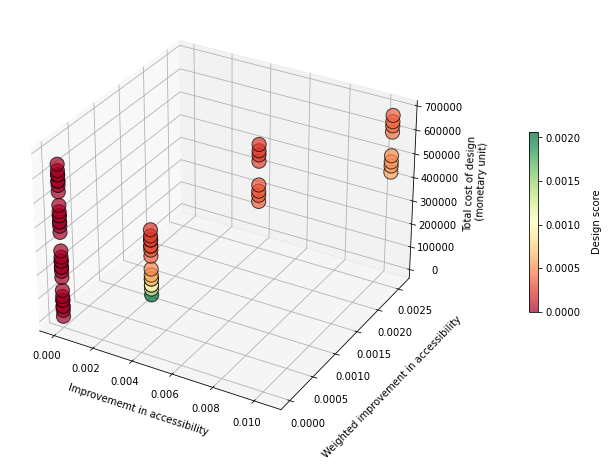

In [156]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter(result_df['delta_alpha_value'], result_df['vulnerable_improvement'],result_df['total_cost'],
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           cmap = 'RdYlGn',
           c=result_df['design_score'])
# for tick in ax.get_xticklabels():
#     tick.set_fontname('DejaVu Sans')
# for tick in ax.get_yticklabels():
#     tick.set_fontname('DejaVu Sans')
# for tick in ax.get_zticklabels():
#     tick.set_fontname('DejaVu Sans')
ax.tick_params(axis='y', pad=8)
ax.tick_params(axis='z', pad=8)
#ax.set_title("3D scatter plot showing the toy problem generated design ouputs.", size=14, **csfont)
ax.set_xlabel("Improvememt in accessibility", labelpad=8, **csfont)
ax.set_ylabel("Weighted improvement in accessibility", labelpad=20, **csfont)
ax.set_zlabel("Total cost of design \n (monetary unit)", labelpad=18, **csfont)

# divider = make_axes_locatable(scat_plot)
# cax = divider.append_axes("bottom", size="5%", pad=0.25)
cb = plt.colorbar(scat_plot, pad=0.15, shrink=0.3, ax=ax)
cb.set_label('Design score', labelpad=12, **csfont)
#cb.ax.tick_params(labelsize=10) 

# fig.savefig('./notebook_figures/3d_results_plot.eps',format='eps', dpi=500, bbox_inches="tight")
fig.savefig("./notebook_figures/3d_results_plot_nobj.png", format = 'png', dpi= 400, bbox_inches="tight")

In [140]:
result_df_cleaned = result_df[['vulnerable_improvement', 'delta_alpha_value', 'total_cost', 'design_score']]
result_df_cleaned = result_df_cleaned.rename(columns={'design_score': 'Design score', 'total_cost':'Total cost',  'delta_alpha_value':"Improvement in Accessibility", 'vulnerable_improvement':'Weighted Improvement'})

In [141]:
result_df_cleaned

,Weighted Improvement,Improvement in Accessibility,Total cost,Design score
0,0.00000,0.00000,10000.0,0.000000
1,0.00000,0.00000,367487.0,0.000000
2,0.00000,0.00000,53091.0,0.000000
3,0.00000,0.00000,410578.0,0.000000
4,0.00000,0.00000,177576.0,0.000000
...,...,...,...,...
59,0.00258,0.01051,505388.0,0.000511
60,0.00074,0.00267,272387.0,0.000271
61,0.00258,0.01051,629874.0,0.000410
62,0.00074,0.00267,315478.0,0.000234


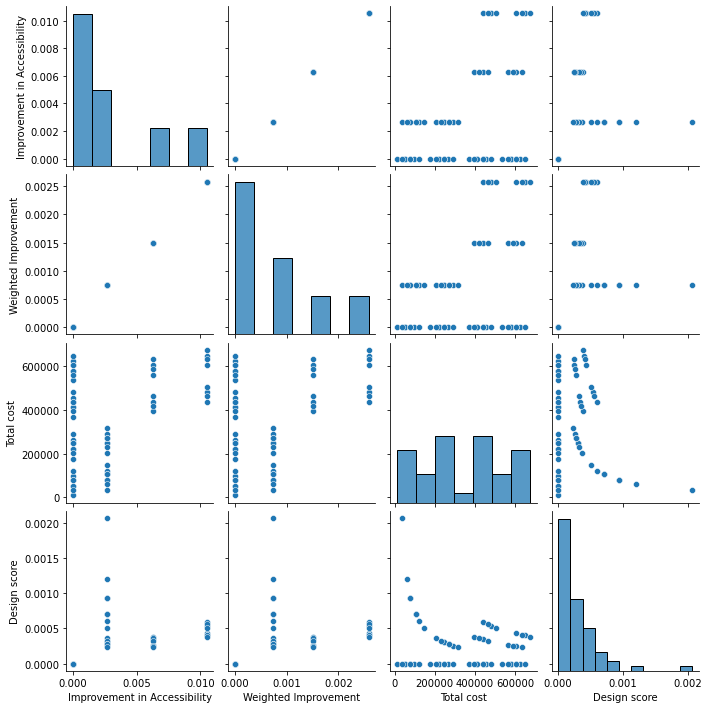

In [142]:
sns.pairplot(result_df_cleaned[["Improvement in Accessibility", 'Weighted Improvement','Total cost', 'Design score']])
# plt.savefig('./notebook_figures/pairplot.eps',format='eps', dpi=1000, bbox_inches="tight")
# plt.savefig('./notebook_figures/pairplot.png',format='png', dpi=1000, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


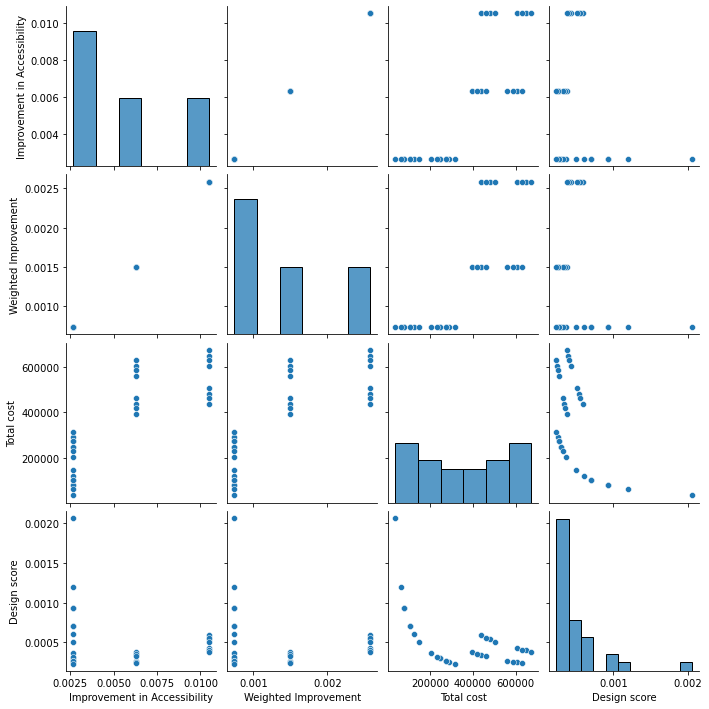

In [143]:
sns.pairplot(result_df_cleaned[["Improvement in Accessibility", 'Weighted Improvement','Total cost', 'Design score']][32:])
plt.savefig('./notebook_figures/pairplot_non-zero_NOBJ.eps',format='eps', dpi=500, bbox_inches="tight")
# plt.savefig('./notebook_figures/pairplot_non-zero.png',format='png', dpi=1000, bbox_inches="tight")

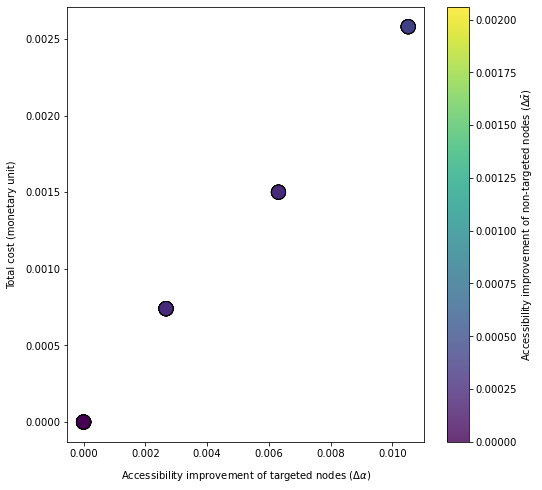

In [144]:
fig, ax = plt.subplots(figsize=(8, 8))
p = ax.scatter(result_df['delta_alpha_value'], result_df['vulnerable_improvement'],
           linewidths=1, alpha=0.8,
           edgecolor='k',
           s = 200,
           cmap = 'viridis',
           c=result_df['design_score'])
ax.set_xlabel("Accessibility improvement of targeted nodes " r'$(\Delta\alpha)$',labelpad=10)
ax.set_ylabel("Total cost (monetary unit)", labelpad=8)
fig.colorbar(p, label="Accessibility improvement of non-targeted nodes " r'$(\Delta\bar\alpha)$')
# plt.xticks(result_df.index, labels=result_df['decision_space_values'], rotation=90)
# fig.savefig('./notebook_figures/result_x_vs_cost.eps',format='eps', dpi=800, bbox_inches="tight")
# fig.savefig("./notebook_figures/result_x_vs_cost.png", format = 'png', dpi= 800, bbox_inches="tight")

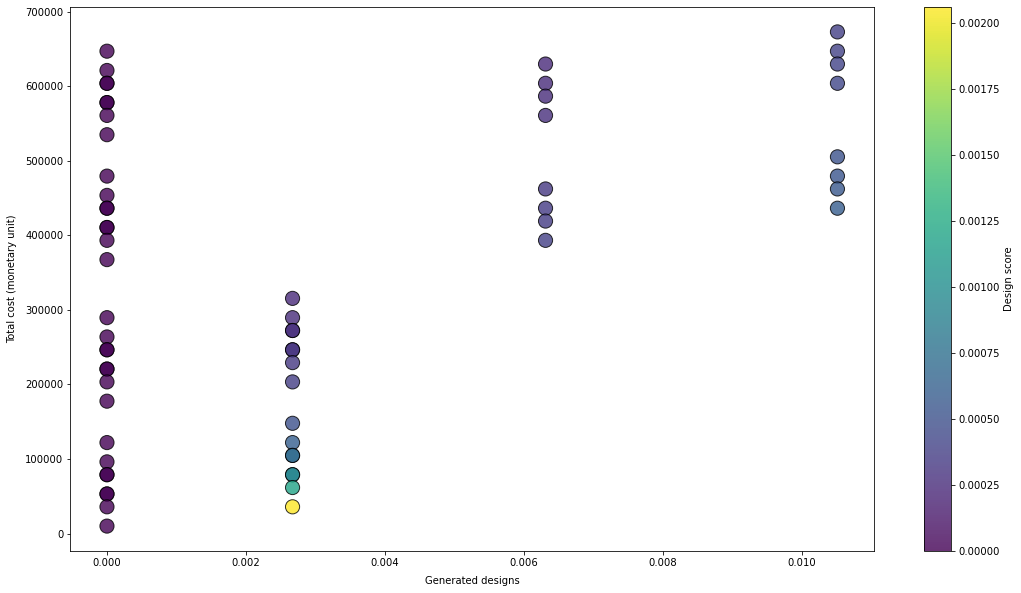

In [145]:
fig, ax = plt.subplots(figsize=(18, 10))
p = ax.scatter(result_df['delta_alpha_value'], result_df['total_cost'],
           linewidths=1, alpha=0.8,
           edgecolor='k',
           s = 200,
           cmap = 'viridis',
           c=result_df['design_score'])
ax.set_xlabel("Generated designs",labelpad=8, **csfont)
ax.set_ylabel("Total cost (monetary unit)", labelpad=8, **csfont)
fig.colorbar(p, label='Design score')
# plt.xticks(result_df.index, labels=result_df['decision_space_values'], rotation=90)
plt.show()
# fig.savefig('./notebook_figures/result_x_vs_cost.eps',format='eps', dpi=1000, bbox_inches="tight")
# fig.savefig("./notebook_figures/result_x_vs_cost.png", format = 'png', dpi= 1000, bbox_inches="tight")

In [146]:
result_quantile_scenario = pd.read_csv("./results/model_quantile_scenario.csv") 
result_quantile_scenario 


,Unnamed: 0,decision_space_values,added_edge_indices,delta_alpha_v,delta_alpha_v_bar,total_cost,design_score
0,0,[0 0 0 0 0 0],[],0.00000,0.00000,10000.0,0.00000
1,1,[0 0 0 0 0 1],"[(16, 30)]",0.00000,0.00000,367487.0,0.00000
2,2,[0 0 0 0 1 0],"[(16, 40)]",0.00000,0.00000,53091.0,0.00000
3,3,[0 0 0 0 1 1],"[(16, 40), (16, 30)]",0.00000,0.00000,410578.0,0.00000
4,4,[0 0 0 1 0 0],"[(30, 39)]",0.00000,0.00000,177576.0,0.00000
...,...,...,...,...,...,...,...
59,59,[1 1 1 0 1 1],"[(30, 24), (24, 30), (40, 16), (16, 40), (16, ...",0.00608,0.00402,505388.0,0.00120
60,60,[1 1 1 1 0 0],"[(30, 24), (24, 30), (40, 16), (30, 39)]",0.00267,0.00000,272387.0,0.00098
61,61,[1 1 1 1 0 1],"[(30, 24), (24, 30), (40, 16), (30, 39), (16, ...",0.00608,0.00402,629874.0,0.00096
62,62,[1 1 1 1 1 0],"[(30, 24), (24, 30), (40, 16), (30, 39), (16, ...",0.00267,0.00000,315478.0,0.00085


In [147]:
# fig,ax=plt.subplots(figsize=(12, 8))
# ax.plot(result_df.design_score[32:], result_df.total_cost[32:], marker="o", color='royalblue')
# ax.set_xlabel("Design score", labelpad=10)
# ax.set_ylabel("Total cost", labelpad=10)

# # twin object for two different y-axis on the sample plot
# # ax2=ax.twinx()
# # # make a plot with different y-axis using second axis object
# # ax2.plot(result_df.design_score[32:], result_df.delta_alpha_v[32:], color="blue",marker="o")
# # ax2.set_ylabel("Improvement in Accessibility",color="blue",fontsize=14)
# plt.show()
# # save the plot as a file
# # fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
# #             format='jpeg',
# #             dpi=100,
# #             bbox_inches='tight')


# # ax.plot(result_df.index[32:], result_df.delta_alpha_v_bar[32:], marker="o", color='lightskyblue')
# # ax.plot(result_quantile_scenario.index[32:], result_quantile_scenario.delta_alpha_v[32:], marker="o", linestyle='dashed', color='firebrick')
# # ax.plot(result_quantile_scenario.index[32:], result_quantile_scenario.delta_alpha_v_bar[32:], marker="o", linestyle='dashed', color='coral')
# # plt.xticks(result_df.index[32:], labels=result_df.decision_space_values[32:], rotation=90)
# # plt.legend([r'$\Delta\alpha$' "(median)", r'$\Delta\bar\alpha$' "(median)", r'$\Delta\alpha$' "(quantile)", r'$\Delta\bar\alpha$' "(quantile)" ], loc="upper left")
# # plt.show()

In [148]:
# fig,ax=plt.subplots(figsize=(12, 8))
# ax.plot(result_df.index[32:], result_df.delta_alpha_v[32:], marker="o", color='royalblue')
# ax.set_xlabel("Generated designs", labelpad=10)
# ax.set_ylabel("Improvement in Accessibility", labelpad=10)
# ax.plot(result_df.index[32:], result_df.delta_alpha_v_bar[32:], marker="o", color='lightskyblue')
# ax.plot(result_quantile_scenario.index[32:], result_quantile_scenario.delta_alpha_v[32:], marker="o", linestyle='dashed', color='firebrick')
# ax.plot(result_quantile_scenario.index[32:], result_quantile_scenario.delta_alpha_v_bar[32:], marker="o", linestyle='dashed', color='coral')
# plt.xticks(result_df.index[32:], labels=result_df.decision_space_values[32:], rotation=90)
# plt.legend([r'$\Delta\alpha$' "(median)", r'$\Delta\bar\alpha$' "(median)", r'$\Delta\alpha$' "(quantile)", r'$\Delta\bar\alpha$' "(quantile)" ], loc="upper left")
# plt.show()

# # fig.savefig('./notebook_figures/a_vs_v_scenario_comparison.eps',format='eps', dpi=500, bbox_inches="tight")
# # fig.savefig("./notebook_figures/a_vs_v_scenario_comparison.png", format = 'png', dpi= 500, bbox_inches="tight")

#### Visualize disaggregated result #1

In [149]:
# Get disaggregated results
x = np.array([1, 0, 0, 0, 0, 1])
delta_alpha_optimal, total_cost, design_result = compute_result_get_vectors(x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index)

In [150]:
delta_alpha_optimal

array([0.00041479, 0.00043589, 0.        , 0.        , 0.        ,
       0.00045792, 0.00052636, 0.        , 0.        , 0.        ,
       0.00041138, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0009362 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00266632, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00046235])

In [151]:
# https://waldyrious.net/viridis-palette-generator/
# Get color dict for vulnerability values
color_dict=  {0.159: '#f0f921', 
                0.195: '#febd2a',
                0.196: '#f48849',
                0.214: '#db5c68',
                0.221: '#b83289',
                0.223: '#8b0aa5',
                0.272: '#5302a3',
                0.277: '#0d0887'}
            

In [152]:
# https://waldyrious.net/viridis-palette-generator/
# Get color dict for vulnerability values
size_dict=  {0.159: 28, 
                0.195: 39,
                0.196: 40,
                0.214: 45,
                0.221: 49,
                0.223: 50,
                0.272: 60,
                0.277: 62}

In [153]:
# # Create marker size based on accessibility improvement of design for every nodes
# list_result = []
# for i in delta_alpha_optimal:
#     y = (i + 40) + (i*60000)
#     list_result.append(y)

In [154]:
# Generate colors for plotting
def case(t):
    if t in v_indices:
        return "red"
    elif t in v_bar_indices:
        return "deepskyblue"
    return "black"

In [155]:
colors= [case(i) for i in n.a_improvement.index.values]

AttributeError: 'GeoDataFrame' object has no attribute 'a_improvement'

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other

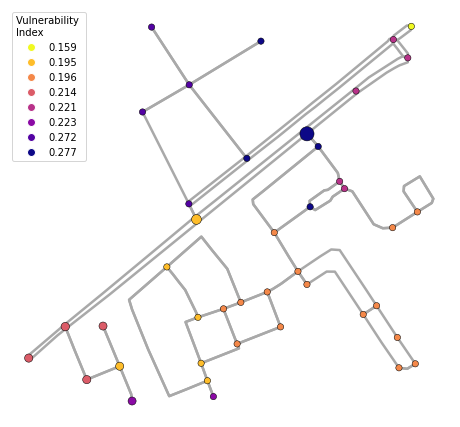

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
e.plot(ax=ax, color='darkgray', linewidth=2.5, zorder=0)
n.plot(ax=ax,  markersize=list_result, zorder=5, linewidth=0.5, edgecolor='black',  c=n['v_final'].map(color_dict))#c=n['s_final'], cmap='Blues')
    #markersize=40,
# for txt, lat, lon in zip(n.index, n.x, n.y):
#     ax.annotate(txt, (lat, lon),
#                 # horizontalalignment="center",
#                 # verticalalignment="bottom" if lon > 0 else "top"
#                 ) #,ha='center'

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color_dict.items()]
ax.legend(title='Vulnerability \nIndex', handles=handles) #, bbox_to_anchor=(1.05, 1), loc='upper left')

# sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=n.s_final.max(), vmax=n.s_final.min()))
# sm._A = []
# cbar = fig.colorbar(sm, shrink=0.5)

ax.set_axis_off()
plt.show()
# fig.savefig('./notebook_figures/s_map.eps',format='eps', dpi=800,bbox_inches="tight")
# fig.savefig("./notebook_figures/s_map.png", format = 'png', dpi= 800, bbox_inches="tight")

### Export delta_alpha as csv for visualisation on QGIS

In [ ]:
n['a_improvement'] = delta_alpha_optimal.tolist()

In [ ]:
n.to_file("./networks/G_nodes_result.shp")

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_24828/1373290292.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  n.to_file("./networks/G_nodes_result.shp")
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


In [ ]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util import plotting
from pymoo.visualization.scatter import Scatter

In [ ]:
# from pymoo.problems import get_problem

In [ ]:
# Model function 
def evaluate_optimisation(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list):

    results_list = []
    for x_i in x:
        results_list.append(evaluate(x_i, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list))
    
    return np.array(results_list)

In [ ]:
class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=6, n_obj=1, n_ieq_constr=0, xl=0, xu=1, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        # a minus sign before the function because the imported optimisaiton is minimisation, to turn it maximisation put an negative sign for now 
        # out["F"] = -compute_result_optimisation(x, G_base, edges_not_in_G_start_ped, walkable_edges, all_poi_nodes_index, alpha_start)
        out["F"] = -evaluate_optimisation(x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index)
        #out["F"] = test_cost_lambda(x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda)
        # out["G"] = x[:, 0] + x[:, 1] - 10

problem = MyProblem()
problem

In [ ]:
# problem = Problem(n_var=6, xl=0, xu=1, vtype=int)
# sampling = BinaryRandomSampling()

# X = sampling(problem, 200).get("X")
# plot = Scatter(tight_layout=True)
# plot.add(X, s=10)
# plot.show()

In [ ]:
# algorithm = GA(pop_size=50,
#             sampling=IntegerRandomSampling(),
#             crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
#             mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
#             eliminate_duplicates=True,
#             )

algorithm = GA(pop_size=70,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               verbose=True,
               save_history=True)

print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % res.F)
#print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       40 | -2.781521E-04 | -1.196647E-03
     2 |       64 | -2.528925E-04 | -2.059594E-03
     3 |       64 | -2.528925E-04 | -2.059594E-03
Best solution found: [1 0 0 0 0 0]
Function value: [-0.00205959]


In this single-objective optimization problem, there exists a single best solution that was found. The result directly contains the best-found values in the corresponding spaces.
If the problem has multiple objectives, the result object has the same structure but res.X, res.F, res .G, res.CV is a set of non-dominated solutions instead of a single one.
So: if i want to see other results (e.g. top 5, then can use pop.get("F") to get a list of all the score for each population in the single optimsation run.)

In [ ]:
pop = res.pop

In [ ]:
# pop.get("X").astype(int)


In [ ]:
# pop.get("F")

In [ ]:
result_df.sort_values(by=['design_score'], ascending=False)

,added_edge_indices,vulnerable_improvement,delta_alpha_value,total_cost,design_score,decision_space_values
32,"[(30, 24)]",0.00074,0.00267,35860.0,0.002060,"[1, 0, 0, 0, 0, 0]"
48,"[(30, 24), (24, 30)]",0.00074,0.00267,61720.0,0.001197,"[1, 1, 0, 0, 0, 0]"
34,"[(30, 24), (16, 40)]",0.00074,0.00267,78951.0,0.000935,"[1, 0, 0, 0, 1, 0]"
40,"[(30, 24), (40, 16)]",0.00074,0.00267,78951.0,0.000935,"[1, 0, 1, 0, 0, 0]"
56,"[(30, 24), (24, 30), (40, 16)]",0.00074,0.00267,104811.0,0.000705,"[1, 1, 1, 0, 0, 0]"
...,...,...,...,...,...,...
31,"[(24, 30), (40, 16), (30, 39), (16, 40), (16, ...",0.00000,0.00000,647105.0,0.000000,"[0, 1, 1, 1, 1, 1]"
1,"[(16, 30)]",0.00000,0.00000,367487.0,0.000000,"[0, 0, 0, 0, 0, 1]"
15,"[(40, 16), (30, 39), (16, 40), (16, 30)]",0.00000,0.00000,621245.0,0.000000,"[0, 0, 1, 1, 1, 1]"
17,"[(24, 30), (16, 30)]",0.00000,0.00000,393347.0,0.000000,"[0, 1, 0, 0, 0, 1]"


In [ ]:
e.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/e.csv')

In [ ]:
# fig, ax = plt.subplots(1, figsize=(8,8))
# # e.plot(ax=ax, color='darkgray', linewidth=2.5, zorder=0)
# e_ped.plot(ax=ax, color='darkgray', linewidth=1.5, zorder=0) 
# for i in sorted_result_df['added_edge_indices'][57]: #loop through the new edge(s) of one generated design
#     new_edges_plot = pd.DataFrame()
#     new_edges_plot= pd.concat([new_edges_plot, e.sort_index().loc[i]]) #search for the edge info in df_e and combine the rows into a dataframe
#     new_edges_plot.plot(ax=ax, color='red', edgecolor='red', linewidth=3, zorder=2)
#     n.iloc[[i[1]]].plot(ax=ax,  markersize=40, edgecolor='black', linewidth=3, marker="o", zorder=5, c='red')#c=n['s_final'], cmap='Blues')

# # axs[idx].set_title(f"{sorted_result_df.iloc[idx]['decision_space_values']} \n {sorted_result_df.iloc[idx]['total_cost']}", fontsize=10, loc='left') ##{idx} - for writing the index 
#     #markersize=40,
# # for txt, lat, lon in zip(n.index, n.x, n.y):
# #     ax.annotate(txt, (lat, lon),
# #                 # horizontalalignment="center",
# #                 # verticalalignment="bottom" if lon > 0 else "top"
# #                 ) #,ha='center'

# # add a legend
# # handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color_dict.items()]
# # ax.legend(title='Vulnerability \nIndex', handles=handles) #, bbox_to_anchor=(1.05, 1), loc='upper left')

# # sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=n.s_final.max(), vmax=n.s_final.min()))
# # sm._A = []
# # cbar = fig.colorbar(sm, shrink=0.5)
# # plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='red')
# # plt.quiver(473516.6121735547, 6811298.284076097)
# # plt.annotate('increase', xy=(473925.344, 6811244.020),xytext=(473953.251744, 6.811212e+06),arrowprops=dict(arrowstyle='->',lw=3.5))
# # ax.set_axis_off()
# plt.show()
# # fig.savefig('./notebook_figures/s_map.eps',format='eps', dpi=800,bbox_inches="tight")
# # fig.savefig("./notebook_figures/s_map.png", format = 'png', dpi= 800, bbox_inches="tight")

In [175]:
sorted_result_df = result_df.sort_values(by=['design_score'], ascending=False)[:4]

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other

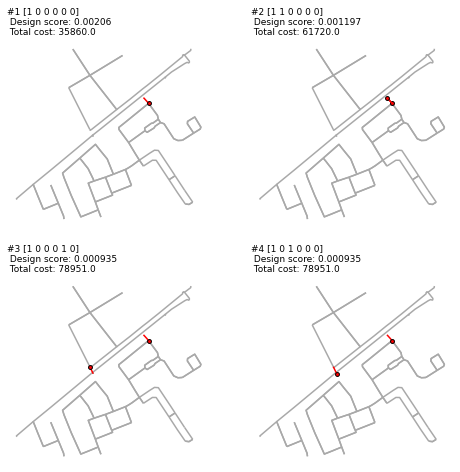

In [179]:
fig, axs = plt.subplots(2,2, figsize=(8, 8)) #, gridspec_kw = {'wspace':0})
# fig, axs = plt.subplots(2,2, figsize=(12, 12)) #, gridspec_kw = {'wspace':0})
axs = axs.flatten()
for idx, design in zip(range(len(axs)), sorted_result_df['added_edge_indices']):
    e_ped.plot(ax=axs[idx], color='darkgray', linewidth=1.5, zorder=0) 
    for i in design: #loop through the new edge(s) of one generated design
        new_edges_plot = pd.DataFrame()
        new_edges_plot= pd.concat([new_edges_plot, e.sort_index().loc[i]]) #search for the edge info in df_e and combine the rows into a dataframe
        new_edges_plot.plot(ax=axs[idx], color='red', edgecolor='red', linewidth=1.5, zorder=1)
        n.iloc[[i[1]]].plot(ax=axs[idx],  markersize=15, edgecolor='black', linewidth=1, marker="o", zorder=1, c='red')#c=n['s_final'], cmap='Blues')
    # trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    # axs[idx].text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='medium', verticalalignment='top', fontfamily='serif')
    axs[idx].set_title(f"#{(idx+1)} {sorted_result_df.iloc[idx]['decision_space_values']} \n Design score: {sorted_result_df.iloc[idx]['design_score']} \n Total cost: {sorted_result_df.iloc[idx]['total_cost']}", fontsize=9, loc='left') ##{idx} - for writing the index 
    axs[idx].axis('off')
# axs[10].axis('off')
# axs[11].axis('off')
plt.show()
# fig.savefig('./notebook_figures/10_optimal_designs_nobj.eps',format='eps', dpi=500, bbox_inches="tight")
fig.savefig("./notebook_figures/4_optimal_designs.png", format = 'png', dpi= 400, bbox_inches="tight")

In [ ]:
# def get_disaggregated_result(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list=all_poi_nodes_index, B=B):
    
#     G_design = generation(x, G_start_edge_list, missing_edges_list)

#     alpha_design = calculate_delta_alpha(G_design, all_poi_nodes_index_list)

#     B_transposed = (B.to_numpy()).transpose()

#     # Get row sum = the number of vertices assigned to each spatial unit
#     avg_per_spatial_unit = np.sum(B_transposed, axis=1) 

#     # Get B_T*alpah_design = the total accessibility improvement in each spatial unit
#     improv_per_spatial_unit = np.dot(B_transposed, alpha_design)

#     # Get the average accessibility improvement in each spatial unit
#     disaggregated_result = []
#     for improv, avg in zip(improv_per_spatial_unit,avg_per_spatial_unit ):
#         disaggregated_result.append(improv/avg)
        
#     return disaggregated_result

In [180]:
B_transposed = (B.to_numpy()).transpose()

In [181]:
def get_disaggregated_result(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list=all_poi_nodes_index, B_transposed=B_transposed):
    
    G_design = generation(x, G_start_edge_list, missing_edges_list)

    alpha_design = calculate_delta_alpha(G_design, all_poi_nodes_index_list)

    # B_transposed = (B.to_numpy()).transpose()

    # Get row sum = the number of vertices assigned to each spatial unit
    avg_per_spatial_unit = np.sum(B_transposed, axis=1) 

    # Get B_T*alpah_design = the total accessibility improvement in each spatial unit
    improv_per_spatial_unit = np.dot(B_transposed, alpha_design)

    # Get the average accessibility improvement in each spatial unit
    disaggregated_result = []
    for improv, avg in zip(improv_per_spatial_unit,avg_per_spatial_unit ):
        # disaggregated_result.append(np.ndarray.item(improv/avg))
        disaggregated_result.append(improv/avg)
        
    return disaggregated_result

In [188]:
sorted_result_df = result_df.sort_values(by=['design_score'], ascending=False)[:32]

In [190]:
for i in sorted_result_df['decision_space_values']:
    optimal = get_disaggregated_result(i, walkable_edges, edges_not_in_G_start_ped)
    print(optimal)

[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.]), array([0.]), array([0.00053326]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[array([0.00038523]), array([0.00057611]), array([0.00075475]), array([0.00008104]), array([0.0004645]), array([0.0002

In [ ]:
# for i in result_df['decision_space_values']:
#     optimal = get_disaggregated_result(i, walkable_edges, edges_not_in_G_start_ped)
#     print(optimal)

In [193]:
v_df_copy = v_df #.drop(['optimal_1', 'optimal_2', 'optimal_3', 'optimal_4', 'optimal_5'], axis=1)
v_df_copy = v_df_copy.reset_index()

In [194]:
for i in range(len(sorted_result_df)):
    optimal = get_disaggregated_result(sorted_result_df['decision_space_values'].iloc[i], walkable_edges, edges_not_in_G_start_ped) #.iloc[i].tolist
    df_optimal = pd.DataFrame(np.stack(optimal))
    df_optimal.columns = [*df_optimal.columns[:-1], f"{i+1}"]
    v_df_copy = pd.concat([v_df_copy, df_optimal], axis=1)

In [195]:
v_df_copy

,area_id,DN,area,neighb_cbs,neigb_cijf,avg_income,Disadvanta,% private,vul_index,n_disad,...,23,24,25,26,27,28,29,30,31,32
0,851,388,47692,Eykenduinen,83 Eykenduynen,45100.0,-10.6,0.502,0.009,0.341,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,922,404,47695,Rosenburg,82 Rosenburg,35000.0,-1.3,0.358,0.012,0.560,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,923,411,47695,Rosenburg,82 Rosenburg,35000.0,-1.3,0.358,0.012,0.560,...,0.000533,0.000533,0.000533,0.000533,0.000533,0.000533,0.000533,0.000533,0.000533,0.000533
3,924,410,47695,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.009,0.449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,997,318,47698,Rosenburg,82 Rosenburg,35000.0,-1.3,0.358,0.009,0.560,...,0.000000,0.000000,0.000000,0.000000,0.000465,0.000465,0.000000,0.000465,0.000465,0.000000
5,998,362,47698,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.008,0.449,...,0.000000,0.000000,0.000000,0.000000,0.000229,0.000229,0.000000,0.000229,0.000229,0.000000
6,999,364,47867,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.008,0.449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1066,413,47700,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.009,0.449,...,0.000000,0.000000,0.000000,0.000000,0.000207,0.000207,0.000000,0.000207,0.000207,0.000000
8,1758,364,47528,Houtwijk,86 Houtwijk,43900.0,-6.0,0.439,0.008,0.449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [196]:
# np.savetxt('/Users/wenyuc/Desktop/Thesis/VSCode/results/optimal_1.csv', optimal_1, delimiter=',')
v_df_copy.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/v_df_optimal_results_all.csv')

In [168]:
common_optimal_edges = sorted_result_df[:10][['decision_space_values']]
common_optimal_edges

,decision_space_values
32,"[1, 0, 0, 0, 0, 0]"
48,"[1, 1, 0, 0, 0, 0]"
34,"[1, 0, 0, 0, 1, 0]"
40,"[1, 0, 1, 0, 0, 0]"
56,"[1, 1, 1, 0, 0, 0]"
50,"[1, 1, 0, 0, 1, 0]"
42,"[1, 0, 1, 0, 1, 0]"
41,"[1, 0, 1, 0, 0, 1]"
57,"[1, 1, 1, 0, 0, 1]"
43,"[1, 0, 1, 0, 1, 1]"


In [169]:
common_optimal_edges = pd.DataFrame(common_optimal_edges['decision_space_values'].tolist())
common_optimal_edges.columns = edges_not_in_G_start_ped
common_optimal_edges

,"(30, 24)","(24, 30)","(40, 16)","(30, 39)","(16, 40)","(16, 30)"
0,1,0,0,0,0,0
1,1,1,0,0,0,0
2,1,0,0,0,1,0
3,1,0,1,0,0,0
4,1,1,1,0,0,0
5,1,1,0,0,1,0
6,1,0,1,0,1,0
7,1,0,1,0,0,1
8,1,1,1,0,0,1
9,1,0,1,0,1,1


In [170]:
common_dict = common_optimal_edges.sum().sort_values(ascending=False).to_dict()
common_dict

{(30, 24): 10, (40, 16): 6, (24, 30): 4, (16, 40): 4, (16, 30): 3, (30, 39): 0}

In [171]:
common_edges_plot = pd.DataFrame()
for i in common_dict:
    edge_to_add = e.sort_index().loc[i]
    edge_to_add['frequency'] = common_dict[i]
    common_edges_plot= pd.concat([common_edges_plot, edge_to_add])

In [172]:
common_edges_plot

,osmid,name,highway,maxspeed,oneway,length,geometry,u_original,v_original,lanes,ref,bridge,frequency
key,,,,,,,,,,,,,
0,"[151331389, 151331390, 51980151]",NaN,cycleway,NaN,False,25.860000,"LINESTRING (473925.344 6811244.020, 473932.591...",662847574,45074199,NaN,NaN,yes,10
0,51677671,NaN,cycleway,NaN,False,43.090662,"LINESTRING (473631.772 6811069.949, 473634.110...",1168763623,1168763779,NaN,NaN,NaN,6
0,"[151331389, 151331390, 51980151]",NaN,cycleway,NaN,False,25.860000,"LINESTRING (473953.252 6811212.497, 473947.007...",45074199,662847574,NaN,NaN,yes,4
0,51677671,NaN,cycleway,NaN,False,43.090662,"LINESTRING (473650.646 6811031.212, 473647.045...",1168763779,1168763623,NaN,NaN,NaN,4
0,397274917,Oude Haagweg,cycleway,NaN,True,357.486992,"LINESTRING (473650.646 6811031.212, 473654.248...",4000841458,662847574,NaN,NaN,NaN,3
0,397274917,Oude Haagweg,cycleway,NaN,True,167.576484,"LINESTRING (473925.344 6811244.020, 474050.923...",662847574,3966690590,NaN,NaN,NaN,0


In [ ]:
common_edges_plot.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/edge_optimal_frequency.csv')

In [ ]:
common_edges_plot[["geometry",'frequency']].to_file("./networks/common_edges_plot.shp")

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


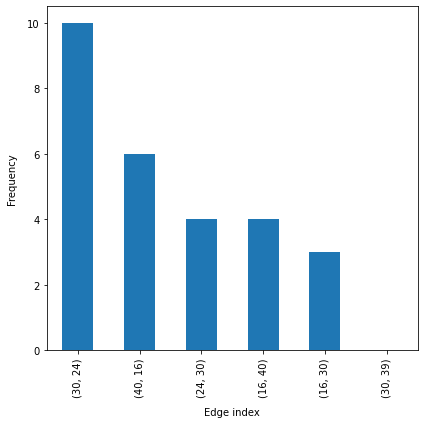

In [174]:
ax = common_optimal_edges.sum().sort_values(ascending=False).plot(kind='bar', figsize=(6, 6))
# ax.legend(title = r'$\lambda$' ' value',bbox_to_anchor=(1.01, 1.02), loc='upper left')
ax.set_ylabel('Frequency', labelpad=10)
ax.set_xlabel('Edge index',labelpad=10)
ax.set_yticks(np.arange(0, 11, 2))
# ax.get_legend().remove()
# plt.xticks(no_unit_cost_df.index, labels=plot_label.decision_space_values, rotation=90)
plt.tight_layout()
plt.savefig('./notebook_figures/frequency_edge_bar_chart.eps',format='eps', dpi=500, bbox_inches="tight")
plt.savefig("./notebook_figures/frequency_edge_bar_chart.png", format = 'png', dpi= 500, bbox_inches="tight")
plt.show()

# 6. Scenario Analysis

#### 6.1 Weight of cost ($\lambda$)

In [ ]:
# Generate a range of cost_lambda values
# np.arange(start=1/1000000, stop=1/10, step=0.01, dtype=None)
# lambda_range= np.arange(start=1/10000000000000, stop=1/100000000, step=9.9999e-10, dtype=None)
# lambda_range

In [ ]:
1/100000000000*35860.0

3.586e-07

In [ ]:
lambda_range = np.array([1/100000000000, 1/10000000000,1/1000000000,1/100000000,1/10000000,1/1000000, 1/100000, 1/10000, 1/1000, 1/100])
lambda_range

array([0.        , 0.        , 0.        , 0.00000001, 0.0000001 ,
       0.000001  , 0.00001   , 0.0001    , 0.001     , 0.01      ])

In [ ]:
# np.savetxt('./data/lambda_range.txt', lambda_range, delimiter=',')

In [ ]:
# def test_cost_lambda(x, lambda_range, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list):
#     """
#     Create a function that calls the evaluate function for every single value in the range of parameters
#     """
#     for cost_i in lambda_range:
#         for i in range(len(sorted_x)):
#             new_edges, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result = compute_result(sorted_x[i], edges_not_in_G_start_ped, walkable_edges, all_poi_nodes_index, cost_i)
#             result_df = pd.concat([result_df, pd.DataFrame.from_records([{'cost_parameter':cost_i, 'x':sorted_x[i], 'new_edges': new_edges, 'delta_alpha_v': delta_alpha_v, 'delta_alpha_v_bar': delta_alpha_v_bar, 'total_cost': total_cost,'design_result': design_result}])], ignore_index=True)
#         # y = evaluate_optimisation(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, cost_lambda) #cost_lambda=cost_i
        

In [ ]:
# With x[i] in the result table

result_df = pd.DataFrame(columns=['new_edges', 'vulnerable_improvement', 'delta_alpha_value', 'total_cost', 'design_result'])
for i in range(len(sorted_x)):
    new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result = compute_result(sorted_x[i], walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index)
    result_df = pd.concat([result_df, pd.DataFrame.from_records([{'x':sorted_x[i], 'new_edges': new_edges, 'delta_alpha_value': delta_alpha_value, 'vulnerable_improvement': vulnerable_improvement, 'total_cost': total_cost, 'design_result': design_result}])], ignore_index=True)

result_df

In [ ]:
# lambda scenario: with brute force 
Z = pd.DataFrame()
for cost_i in lambda_range:
        z = pd.DataFrame()
        for i in sorted_x:
                new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result  = compute_result(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=cost_i)
                z = pd.concat([z, pd.DataFrame.from_records([{'x':i, 'new_edges': new_edges, 'delta_alpha_value': delta_alpha_value, 'vulnerable_improvement': vulnerable_improvement, 'cost_lambda': cost_i, 'scaled_cost': total_cost*cost_i, 'design_result': design_result}])], ignore_index=True)
                optimal = z.iloc[[z['design_result'].idxmax()]]       
        Z = pd.concat([Z, optimal], ignore_index=True)
Z

,x,new_edges,delta_alpha_value,vulnerable_improvement,cost_lambda,scaled_cost,design_result
0,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-11,3.586000e-07,2059.593848
1,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-10,3.586000e-06,205.959385
2,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-09,3.586000e-05,20.595938
3,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-08,3.586000e-04,2.059594
4,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-07,3.586000e-03,0.205959
5,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-06,3.586000e-02,0.020596
6,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-05,3.586000e-01,0.002060
7,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-04,3.586000e+00,0.000206
8,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-03,3.586000e+01,0.000021
9,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-02,3.586000e+02,0.000002


In [ ]:
lambda_range[9]

0.01

In [ ]:
# # Model function: version 3.0 with cost separated from objective function and lambda
def compute_result_z(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, base_G=G_base, alpha_start=alpha_start, n=n, v_final=v_final, cost_fixed=cost_fixed, cost_unit=cost_unit, cost_lambda=cost_lambda, m_design=m_design, l_x=l_x):
    
    """
    Inputs:
        missing_edges_list - list of edges that are absent in the starting subgraph of a transport mode (e.g. edges_not_in_G_start_ped)
        G_start_edge_list - list of edges that build the G_start for a transport mode (e.g. walkable_edges)
        all_poi_nodes_index_list - list of nodes that represent POIs
    """

    # 1. GENERATION
    # extract indices from non-zeros of x
    indices_of_new_edges = []
    for index in range(len(x)):
        if x[index] > 0:
            indices_of_new_edges.append(index)
    
    # extract edge keys with the indices
    new_edges = [missing_edges_list[i] for i in indices_of_new_edges]

    # add a zero in the end of give each tuple a u,v,k structure in order to build subgraph without error
    new_edges_complete = [i + (0,) for i in new_edges]

    # list concatenation to add the new edges to the subgraph's edge list
    edges_design = G_start_edge_list + new_edges_complete

    # create G_design with the new edge list
    G_design = base_G.edge_subgraph(edges_design)

    # 2. CALCULATE ACCESSIBILITY (alpha)
    # call the function that calculates shortest path
    alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

    # 3. EVALUATE (OBJECTIVE FUNCTION)
    delta_alpha = alpha_design - alpha_start 
    delta_alpha_value = np.sum(delta_alpha)
    # vulnerable_improvement = np.ndarray.item(np.dot((np.ones((len(n)), dtype=int)), (np.multiply(v_final, np.reshape(delta_alpha, (len(n),1))))))
    vulnerable_improvement = np.ndarray.item(np.dot(v_final.transpose(), np.reshape(delta_alpha, (len(n),1))))
    total_cost = cost_fixed + np.ndarray.item((np.dot((np.ones(m_design, dtype=int)), cost_unit*np.multiply(np.reshape(x, (m_design,1)), l_x))))
    design_result = (1+vulnerable_improvement)/(1+(cost_lambda*total_cost))
    
    #return x, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result 
    return new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result      #we need delta_alpha for disaggregated results

In [ ]:
z = pd.DataFrame()
for i in sorted_x:
    new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result  = compute_result_z(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[3])
    z = pd.concat([z, pd.DataFrame.from_records([{'x':i, 'design_result': design_result}])], ignore_index=True)
z.sort_values(by=['design_result'], ascending=False)[:5]
    #     optimal = z.sort_values(by=['design_result'], ascending=False)[:5]
    #     optimal = optimal.reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]
    # print(optimal)

,x,design_result
32,"[1, 0, 0, 0, 0, 0]",1.000380
48,"[1, 1, 0, 0, 0, 0]",1.000121
34,"[1, 0, 0, 0, 1, 0]",0.999949
40,"[1, 0, 1, 0, 0, 0]",0.999949
0,"[0, 0, 0, 0, 0, 0]",0.999900


In [ ]:
z2 = pd.DataFrame()
for i in sorted_x:
    new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result  = compute_result(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[3])
    z2 = pd.concat([z2, pd.DataFrame.from_records([{'x':i, 'design_result': design_result}])], ignore_index=True)
z2.sort_values(by=['design_result'], ascending=False)[:5]
    #     optimal = z.sort_values(by=['design_result'], ascending=False)[:5]
    #     optimal = optimal.reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]
    # print(optimal)

,x,design_result
32,"[1, 0, 0, 0, 0, 0]",2.059594
48,"[1, 1, 0, 0, 0, 0]",1.196647
40,"[1, 0, 1, 0, 0, 0]",0.935483
34,"[1, 0, 0, 0, 1, 0]",0.935483
56,"[1, 1, 1, 0, 0, 0]",0.704671


In [ ]:
z2 = z2.sort_values(by=['design_result'], ascending=False)[:5].reset_index().rename(columns={'index': f"{lambda_range[3]}"})[[f"{lambda_range[3]}"]]

In [ ]:
z = z.sort_values(by=['design_result'], ascending=False)[:5].reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]

In [ ]:
Z = pd.DataFrame()
Z = pd.concat([z, z2], axis=1)
Z

,0.01,1e-08
0,41,32
1,57,48
2,43,40
3,59,34
4,45,56


In [ ]:
Z = pd.DataFrame()
for cost_i in lambda_range:
    z = pd.DataFrame()
    for i in sorted_x:
        new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result  = compute_result(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=cost_i)
        z = pd.concat([z, pd.DataFrame.from_records([{'x':i, 'design_result': design_result}])], ignore_index=True)
    optimal = z.sort_values(by=['design_result'], ascending=False)[:5].reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]
    Z = pd.concat([Z, optimal], axis=1)

Z
# optimal

,1e-11,1e-10,1e-09,1e-08,1e-07,1e-06,1e-05,0.0001,0.001,0.01
0,32,32,32,32,32,32,32,32,32,32
1,48,48,48,48,48,48,48,48,48,48
2,40,40,40,40,40,40,40,40,40,40
3,34,34,34,34,34,34,34,34,34,34
4,56,56,56,56,56,56,56,56,56,56


In [ ]:
Z_1 = pd.DataFrame()
for cost_i in lambda_range:
    z = pd.DataFrame()
    for i in sorted_x:
        new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result = compute_result_z(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=cost_i)
        z = pd.concat([z, pd.DataFrame.from_records([{'x':i, 'design_result': design_result}])], ignore_index=True)
    optimal = z.sort_values(by=['design_result'], ascending=False)[:5].reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]
    Z_1 = pd.concat([Z_1, optimal], axis=1)

Z_1

,1e-11,1e-10,1e-09,1e-08,1e-07,1e-06,1e-05,0.0001,0.001,0.01
0,41,41,41,32,0,0,0,0,0,0
1,57,57,57,48,32,32,32,32,32,32
2,43,43,43,34,16,16,16,16,16,16
3,59,59,59,40,2,2,2,8,8,2
4,45,45,45,0,8,8,8,2,2,8


In [ ]:
z.sort_values(by=['design_result'], ascending=False)

,x,new_edges,delta_alpha_value,vulnerable_improvement,cost_lambda,scaled_cost,design_result
32,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-11,3.586000e-07,2059.593848
48,"[1, 1, 0, 0, 0, 0]","[(30, 24), (24, 30)]",0.002666,0.000739,1.000000e-11,6.172000e-07,1196.646717
40,"[1, 0, 1, 0, 0, 0]","[(30, 24), (40, 16)]",0.002666,0.000739,1.000000e-11,7.895066e-07,935.483426
34,"[1, 0, 0, 0, 1, 0]","[(30, 24), (16, 40)]",0.002666,0.000739,1.000000e-11,7.895066e-07,935.483426
56,"[1, 1, 1, 0, 0, 0]","[(30, 24), (24, 30), (40, 16)]",0.002666,0.000739,1.000000e-11,1.048107e-06,704.671016
...,...,...,...,...,...,...,...
31,"[0, 1, 1, 1, 1, 1]","[(24, 30), (40, 16), (30, 39), (16, 40), (16, ...",0.000000,0.000000,1.000000e-11,6.471048e-06,0.000000
1,"[0, 0, 0, 0, 0, 1]","[(16, 30)]",0.000000,0.000000,1.000000e-11,3.674870e-06,0.000000
15,"[0, 0, 1, 1, 1, 1]","[(40, 16), (30, 39), (16, 40), (16, 30)]",0.000000,0.000000,1.000000e-11,6.212448e-06,0.000000
17,"[0, 1, 0, 0, 0, 1]","[(24, 30), (16, 30)]",0.000000,0.000000,1.000000e-11,3.933470e-06,0.000000


In [ ]:
Z = pd.DataFrame()
z = pd.DataFrame()
for i in sorted_x:
    new_edges, delta_alpha_value, vulnerable_improvement, total_cost, design_result  = compute_result(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=cost_i)
    z = pd.concat([z, pd.DataFrame.from_records([{'x':i, 'new_edges': new_edges, 'delta_alpha_value': delta_alpha_value, 'vulnerable_improvement': vulnerable_improvement, 'cost_lambda': cost_i, 'scaled_cost': total_cost*cost_i, 'design_result': design_result}])], ignore_index=True)
    optimal = z.sort_values(by=['design_result'], ascending=False)[:5]
    optimal = optimal.reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]
Z = pd.concat([Z, optimal], ignore_index=True)
print(Z)

   1e-11
0     32
1     48
2     40
3     34
4     56


In [ ]:
optimal.reset_index().rename(columns={'index': f"{cost_i}"})[[f"{cost_i}"]]

,1e-11,1e-11
0,0,32
1,1,48
2,2,40
3,3,34
4,4,56


In [ ]:
optimal = z.sort_values(by=['design_result'], ascending=False)[:5]
optimal

,x,new_edges,delta_alpha_value,vulnerable_improvement,cost_lambda,scaled_cost,design_result
32,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.002666,0.000739,1.000000e-11,3.586000e-07,2059.593848
48,"[1, 1, 0, 0, 0, 0]","[(30, 24), (24, 30)]",0.002666,0.000739,1.000000e-11,6.172000e-07,1196.646717
40,"[1, 0, 1, 0, 0, 0]","[(30, 24), (40, 16)]",0.002666,0.000739,1.000000e-11,7.895066e-07,935.483426
34,"[1, 0, 0, 0, 1, 0]","[(30, 24), (16, 40)]",0.002666,0.000739,1.000000e-11,7.895066e-07,935.483426
56,"[1, 1, 1, 0, 0, 0]","[(30, 24), (24, 30), (40, 16)]",0.002666,0.000739,1.000000e-11,1.048107e-06,704.671016


In [ ]:
optimal.reset_index().rename(columns={'index': 'bar'})[['bar']]


,bar
0,32
1,48
2,40
3,34
4,56
5,50
6,42
7,41
8,57
9,43


In [ ]:
# # lambda scenario: with brute force 
# for cost_i in lambda_range[:10]:
#         z = pd.DataFrame()
#         for i in sorted_x:
#                 new_edges, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result = compute_result(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_i)
#                 z = pd.concat([z, pd.DataFrame.from_records([{'new_edges': new_edges, 'delta_alpha_v': float(delta_alpha_v), 'delta_alpha_v_bar': float(delta_alpha_v_bar), 'total_cost': float(total_cost),'design_result': float(design_result), 'cost_lambda': cost_i, 'x':i, 'scaled_cost':float(total_cost)*cost_i}])], ignore_index=True)
#                 optimal = z.iloc[[z['design_result'].idxmax()]]       
#         print(optimal.squeeze())

In [ ]:
Z["delta_alpha_value"] = round(Z.delta_alpha_value.astype(float),5)
Z["vulnerable_improvement"] = round(Z.vulnerable_improvement.astype(float),5)
Z["cost_lambda"] = Z.cost_lambda.astype(float)
Z["design_result"] = round(Z.design_result.astype(float),5)
Z["scaled_cost"] = round(Z.scaled_cost.astype(float),5)

In [ ]:
Z = Z[['cost_lambda', 'x', 'new_edges', 'delta_alpha_v', 'delta_alpha_v_bar', 'total_cost', 'scaled_cost', 'design_result']]
# Z = Z.rename(columns={'x': 'decision_space_values', 'new_edges': 'added_edge_indices', 'design_result': 'design_score','cost_lambda': 'lambda_value' })

In [ ]:
Z

,x,new_edges,delta_alpha_value,vulnerable_improvement,cost_lambda,scaled_cost,design_result
0,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-11,0.00000,2059.59385
1,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-10,0.00000,205.95938
2,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-09,0.00004,20.59594
3,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-08,0.00036,2.05959
4,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-07,0.00359,0.20596
5,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-06,0.03586,0.02060
6,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-05,0.35860,0.00206
7,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-04,3.58600,0.00021
8,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-03,35.86000,0.00002
9,"[1, 0, 0, 0, 0, 0]","[(30, 24)]",0.00267,0.00074,1.000000e-02,358.60000,0.00000


In [ ]:
# Z.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/lambda_test.csv')

In [ ]:
# lambda scenario: with GA
for cost_i in lambda_range:
    print(cost_i)
    
    class MyProblem_lambda(Problem):

        def __init__(self):
            super().__init__(n_var=6, n_obj=1, n_ieq_constr=0, xl=0, xu=1, vtype=int)

        def _evaluate(self, x, out, *args, **kwargs):
            # a minus sign before the function because the imported optimisaiton is minimisation, to turn it maximisation put an negative sign for now 
            out["F"] = -evaluate_optimisation(x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=cost_i)
    
    problem = MyProblem_lambda()
    
    res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               verbose=True,
               save_history=True)

    print("Best solution found: %s" % res.X.astype(int))
    print("Function value: %s" % res.F)

1e-11


TypeError: evaluate_optimisation() got an unexpected keyword argument 'cost_lambda'

#### 6.2 Weight of cost ($\lambda$) without cost_unit

In [ ]:
def evaluate_without_cost_unit(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, cost_lambda, cost_fixed=cost_fixed, l_x=l_x, m_design=m_design): #cost_unit=cost_unit,
    
    """
    Inputs:
        missing_edges_list - list of edges that are absent in the starting subgraph of a transport mode (e.g. edges_not_in_G_start_ped)
        G_start_edge_list - list of edges that build the G_start for a transport mode (e.g. walkable_edges)
        all_poi_nodes_index_list - list of nodes that represent POIs (e.g. all_poi_nodes_index))
    """
    # 1. GENERATION
    #G_design = generation(x, G_start_edge_list, missing_edges_list)
    G_design = generation(x, G_start_edge_list, missing_edges_list)
    
    # 3. CALCULATE ACCESSIBILITY OF GENERATED DESIGN
    alpha_design = calculate_accessibility(G_design, all_poi_nodes_index_list)

    # 4. CALCULATE ACCESSIBILITY IMPROVEMENT
    delta_alpha_v, delta_alpha_v_bar = calculate_accessibility_improvement(alpha_design)

    # 5. EVALUATE
    # total_cost = (cost_fixed + np.ndarray.item(cost_unit * np.dot((np.ones((m_design), dtype=int)), (np.reshape(x, (m_design,1)) * l_x))))
    # design_result = delta_alpha_v / (delta_alpha_v_bar + (cost_lambda * total_cost))
    total_cost = (cost_lambda * cost_fixed)
    design_result = delta_alpha_v / (delta_alpha_v_bar + total_cost)
    
    #return design_result   #for optimisation
    return delta_alpha_v, delta_alpha_v_bar, total_cost, design_result

# Model function 
def evaluate_optimisation_without_cost_unit(x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, cost_lambda):

    results_list = []
    for x_i in x:
        results_list.append(evaluate_without_cost_unit(x_i, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, cost_lambda))
    
    return np.array(results_list)

In [ ]:
# # lambda scenario without cost_unit: with brute force 
# Z = pd.DataFrame()
# for cost_i in lambda_range[6]:
#         z = pd.DataFrame()
#         for i in sorted_x:
#                 new_edges, delta_alpha_v, delta_alpha_v_bar, total_cost, design_result = evaluate_without_cost_unit(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_i)
#                 z = pd.concat([z, pd.DataFrame.from_records([{'new_edges': new_edges, 'delta_alpha_v': float(delta_alpha_v), 'delta_alpha_v_bar': float(delta_alpha_v_bar), 'scaled_cost': float(total_cost),'design_result': float(design_result), 'cost_lambda': cost_i, 'x':i}])], ignore_index=True)
#                 # optimal = z.iloc[[z['design_result'].idxmax()]]  
#                 # Z = pd.concat([Z, optimal], ignore_index=True)


In [ ]:
z2 = pd.DataFrame()
for i in sorted_x:
    delta_alpha_v, delta_alpha_v_bar, total_cost, design_result = evaluate_without_cost_unit(i, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, lambda_range[7])
    z2 = pd.concat([z2, pd.DataFrame.from_records([{'delta_alpha_v': float(delta_alpha_v), 'delta_alpha_v_bar': float(delta_alpha_v_bar), 'scaled_cost': float(total_cost),'design_result': float(design_result), 'cost_lambda': lambda_range[7], 'x':i}])], ignore_index=True)
z2

,delta_alpha_v,delta_alpha_v_bar,scaled_cost,design_result,cost_lambda,x
0,0.000000,0.000000,1.0,0.000000,0.0001,"[0, 0, 0, 0, 0, 0]"
1,0.000000,0.000000,1.0,0.000000,0.0001,"[0, 0, 0, 0, 0, 1]"
2,0.000000,0.000000,1.0,0.000000,0.0001,"[0, 0, 0, 0, 1, 0]"
3,0.000000,0.000000,1.0,0.000000,0.0001,"[0, 0, 0, 0, 1, 1]"
4,0.000000,0.000000,1.0,0.000000,0.0001,"[0, 0, 0, 1, 0, 0]"
...,...,...,...,...,...,...
59,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 1, 1, 0, 1, 1]"
60,0.002666,0.000000,1.0,0.002666,0.0001,"[1, 1, 1, 1, 0, 0]"
61,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 1, 1, 1, 0, 1]"
62,0.002666,0.000000,1.0,0.002666,0.0001,"[1, 1, 1, 1, 1, 0]"


In [ ]:
z2.sort_values(by=['design_result'], ascending=False)[:20]

,delta_alpha_v,delta_alpha_v_bar,scaled_cost,design_result,cost_lambda,x
63,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 1, 1, 1, 1, 1]"
61,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 1, 1, 1, 0, 1]"
59,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 1, 1, 0, 1, 1]"
57,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 1, 1, 0, 0, 1]"
41,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 0, 1, 0, 0, 1]"
43,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 0, 1, 0, 1, 1]"
45,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 0, 1, 1, 0, 1]"
47,0.008230,0.001757,1.0,0.008215,0.0001,"[1, 0, 1, 1, 1, 1]"
51,0.004413,0.001372,1.0,0.004407,0.0001,"[1, 1, 0, 0, 1, 1]"
35,0.004413,0.001372,1.0,0.004407,0.0001,"[1, 0, 0, 0, 1, 1]"


In [ ]:
z.sort_values(by=['design_result'], ascending=False)[:50]

,new_edges,delta_alpha_v,delta_alpha_v_bar,total_cost,design_result,cost_lambda,x,scaled_cost
32,"[(30, 24)]",0.002666,0.000000,35860.000000,7.435357e-06,0.01,"[1, 0, 0, 0, 0, 0]",358.600000
48,"[(30, 24), (24, 30)]",0.002666,0.000000,61720.000000,4.320024e-06,0.01,"[1, 1, 0, 0, 0, 0]",617.200000
40,"[(30, 24), (40, 16)]",0.002666,0.000000,78950.661574,3.377196e-06,0.01,"[1, 0, 1, 0, 0, 0]",789.506616
34,"[(30, 24), (16, 40)]",0.002666,0.000000,78950.661574,3.377196e-06,0.01,"[1, 0, 0, 0, 1, 0]",789.506616
56,"[(30, 24), (24, 30), (40, 16)]",0.002666,0.000000,104810.661574,2.543939e-06,0.01,"[1, 1, 1, 0, 0, 0]",1048.106616
50,"[(30, 24), (24, 30), (16, 40)]",0.002666,0.000000,104810.661574,2.543939e-06,0.01,"[1, 1, 0, 0, 1, 0]",1048.106616
42,"[(30, 24), (40, 16), (16, 40)]",0.002666,0.000000,122041.323148,2.184767e-06,0.01,"[1, 0, 1, 0, 1, 0]",1220.413231
41,"[(30, 24), (40, 16), (16, 30)]",0.008230,0.001757,436437.653944,1.885678e-06,0.01,"[1, 0, 1, 0, 0, 1]",4364.376539
58,"[(30, 24), (24, 30), (40, 16), (16, 40)]",0.002666,0.000000,147901.323148,1.802769e-06,0.01,"[1, 1, 1, 0, 1, 0]",1479.013231
57,"[(30, 24), (24, 30), (40, 16), (16, 30)]",0.008230,0.001757,462297.653944,1.780197e-06,0.01,"[1, 1, 1, 0, 0, 1]",4622.976539


In [ ]:
# Get all optimal designs from every lambda range element
def evaluate_without_cost_unit_dataframe(sorted_x, G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, cost_lambda):
        z = pd.DataFrame()
        for i in range(len(sorted_x)):
                delta_alpha_v, delta_alpha_v_bar, total_cost, design_result = evaluate_without_cost_unit(sorted_x[i], G_start_edge_list, missing_edges_list, all_poi_nodes_index_list, cost_lambda)
                z = pd.concat([z, pd.DataFrame.from_records([{'delta_alpha_v': round(float(delta_alpha_v),5), 'delta_alpha_v_bar': round(float(delta_alpha_v_bar),5), 'scaled_cost': round(float(total_cost),5),'design_result': round(float(design_result),5), 'cost_lambda': cost_lambda, 'x':sorted_x[i]}])], ignore_index=True)
        output = z.loc[z['design_result'] == z['design_result'].max()]
        output[cost_lambda] = int(1)
        ouput_to_merge = output[[cost_lambda]]
        return output, ouput_to_merge

In [ ]:
# Run optimisation without cost_unit for every element in lambda_range, change each cost_lambda for every output dataframe here
# For walk network
output_lambda_1, output_lambda_1_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[0])
output_lambda_2, output_lambda_2_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[1])
output_lambda_3, output_lambda_3_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[2])
output_lambda_4, output_lambda_4_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[3])
output_lambda_5, output_lambda_5_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[4])
output_lambda_6, output_lambda_6_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[5])
output_lambda_7, output_lambda_7_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[6])
output_lambda_8, output_lambda_8_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[7])
output_lambda_9, output_lambda_9_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[8])
output_lambda_10, output_lambda_10_merge = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[9])

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_2896/3207509843.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[cost_lambda] = int(1)
/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_2896/3207509843.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[cost_lambda] = int(1)
/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_2896/3207509843.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [ ]:
output_lambda_1 = output_lambda_1[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_1.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_1.csv')
output_lambda_2 = output_lambda_2[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_2.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_2.csv')
output_lambda_3 = output_lambda_3[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_3.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_3.csv')
output_lambda_4 = output_lambda_4[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_4.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_4.csv')
output_lambda_5 = output_lambda_5[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_5.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_5.csv')
output_lambda_6 = output_lambda_6[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_6.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_6.csv')
output_lambda_7 = output_lambda_7[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_7.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_7.csv')
output_lambda_8 = output_lambda_8[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_8.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_8.csv')
output_lambda_9 = output_lambda_9[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_9.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_9.csv')
output_lambda_10 = output_lambda_10[['x','delta_alpha_v', 'delta_alpha_v_bar', 'scaled_cost', 'design_result']]
output_lambda_10.to_csv('/Users/wenyuc/Desktop/Thesis/VSCode/results/output_lambda_10.csv')

In [ ]:
output_dataframe_list = [output_lambda_1_merge, 
                        output_lambda_2_merge,
                        output_lambda_3_merge,
                        output_lambda_4_merge,
                        output_lambda_5_merge,
                        output_lambda_6_merge,
                        output_lambda_7_merge,
                        output_lambda_8_merge,
                        output_lambda_9_merge,
                        output_lambda_10_merge,
                        ]
no_unit_cost_df = pd.concat(output_dataframe_list, axis=1)

In [ ]:
no_unit_cost_df = no_unit_cost_df.reset_index()

In [ ]:
list(no_unit_cost_df['index'].values)

[32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 41,
 43,
 45,
 47,
 57,
 59,
 61,
 63]

In [ ]:
plot_label = result_df.iloc[list(no_unit_cost_df['index'].values)][['decision_space_values']]

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


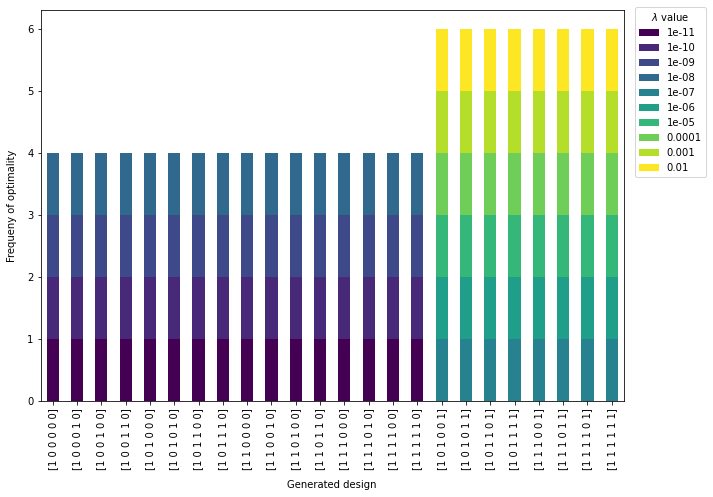

In [ ]:
ax = no_unit_cost_df.plot(x='index', kind='bar', stacked=True, figsize=(10, 7),cmap='viridis')
ax.legend(title = r'$\lambda$' ' value',bbox_to_anchor=(1.01, 1.02), loc='upper left')
ax.set_ylabel('Frequeny of optimality', labelpad=10)
ax.set_xlabel('Generated design',labelpad=10)
plt.xticks(no_unit_cost_df.index, labels=plot_label.decision_space_values, rotation=90)
plt.tight_layout()
plt.savefig('./notebook_figures/lambda_no_cost_unit.eps',format='eps', dpi=1000, bbox_inches="tight")
plt.savefig("./notebook_figures/lambda_no_cost_unit.png", format = 'png', dpi= 1000, bbox_inches="tight")
plt.show()

In [ ]:
# fig, ax = plt.subplots()

# # for col in range(len(no_unit_cost_df.columns)):
# #     y = 
# ax.bar(no_unit_cost_df.index, no_unit_cost_df.iloc[:, 0], label=no_unit_cost_df.columns[0], color=colors[0], bottom=no_unit_cost_df.iloc[:, 0])
# ax.bar(no_unit_cost_df.index, no_unit_cost_df.iloc[:, 1], label=no_unit_cost_df.columns[1], color=colors[1], bottom=no_unit_cost_df.iloc[:, 0]+no_unit_cost_df.iloc[:, 1])

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.legend()

# plt.show()

In [ ]:
# z_lambda_range_2 = evaluate_without_cost_unit_dataframe(sorted_x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[2])
# z_lambda_range_2.sort_values(by=['design_result'], ascending=False)[:20]

In [ ]:
# lambda scenario without cost_unit: with GA
for cost_i in lambda_range:
    print(cost_i)
    
    class MyProblem_lambda(Problem):

        def __init__(self):
            super().__init__(n_var=6, n_obj=1, n_ieq_constr=0, xl=0, xu=1, vtype=int)

        def _evaluate(self, x, out, *args, **kwargs):
            # a minus sign before the function because the imported optimisaiton is minimisation, to turn it maximisation put an negative sign for now 
            out["F"] = -evaluate_optimisation_without_cost_unit(x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=cost_i)
    
    problem = MyProblem_lambda()
    
    res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               verbose=True,
               save_history=True)

    print("Best solution found: %s" % res.X.astype(int))
    print("Function value: %s" % res.F)

1e-11


Exception: ('Problem Error: F can not be set, expected shape (41, 1) but provided (41, 4)', ValueError('cannot reshape array of size 164 into shape (41,1)'))

Try create a dataframe showing the changes in design outputs/the optimal design when cost_unit is not considered. (maybe a bar graph with x in the x-axis and frequency of a decision being the best on y)

In [ ]:
class MyProblem_lambda(Problem):

        def __init__(self):
            super().__init__(n_var=6, n_obj=1, n_ieq_constr=0, xl=0, xu=1, vtype=int)

        def _evaluate(self, x, out, *args, **kwargs):
            # a minus sign before the function because the imported optimisaiton is minimisation, to turn it maximisation put an negative sign for now 
            out["F"] = -evaluate_optimisation_without_cost_unit(x, walkable_edges, edges_not_in_G_start_ped, all_poi_nodes_index, cost_lambda=lambda_range[2])
    
problem = MyProblem_lambda()
    
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               verbose=True,
               save_history=True)

print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % res.F)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       47 | -3.536447E+01 | -1.333106E+02
     2 |       64 | -3.430270E+01 | -1.333106E+02
     3 |       64 | -3.430270E+01 | -1.333106E+02
Best solution found: [1 0 1 1 0 0]
Function value: [-133.3106159]


In [ ]:
pop = res.pop
pop.get("X").astype(int)

array([[1, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 1, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 1],
       [1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1],
 

In [ ]:
pop.get("F")

array([[-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [-133.3106159 ],
       [  -4.63044936],
       [  -4.63044936],
       [  -4.63044936],
       [  -4.63044936],
       [  -4.63044936],
       [  -4.63044936],
       [  -4.63044936],
       [  -4.63044936],
       [  -3.16988538],
       [  -3.16988538],
       [  -3.16988538],
       [  -3.16988538],
       [  -3.16988538],
       [  -3.16988538],
       [  -3.16988538],
       [  -3.16988538],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.        ],
       [  -0.   

In [ ]:
output = np.concatenate((pop.get("X").astype(int), pop.get("F")), axis=1) 

In [ ]:
# from pymoo.problems.single.knapsack import create_random_knapsack_problem

# problem = create_random_knapsack_problem(30)


# algorithm = GA(pop_size=200,
#                sampling=BinaryRandomSampling(),
#                crossover=HUX(),
#                mutation=BitflipMutation(),
#                eliminate_duplicates=True)


# res = minimize(problem,
#                algorithm,
#                termination=('n_gen', 10),
#                verbose=True)

# print("Best solution found: %s" % res.X.astype(int))
# print("Function value: %s" % res.F)

In [ ]:
n_design, e_design = ox.graph_to_gdfs(G_design_ped)

NameError: name 'G_design_ped' is not defined

In [ ]:
# extract indices from non-zeros of x
indices_of_optimal_edges = []
for index in range(len(x)):             # x = res.X.astype(int)
    if x[index] > 0:
        indices_of_optimal_edges.append(index)
# extract edge keys with the indices
optimal_edges = [edges_not_in_G_start_ped[i] for i in indices_of_optimal_edges]
optimal_edges

[(30, 24), (40, 16)]

In [ ]:
# Changing the highway attribute value of edges in the optimal solution 
# So they can be called when coloring the edges for visualisation (cannot figure out another way to do this)
for i in range(len(optimal_edges)):
    u = optimal_edges[i][0] 
    v = optimal_edges[i][1]
    G_design_ped[u][v][0]['highway'] = 0

In [ ]:
def plot_optimal_result(G_start, G_start_edge_list):
    

    ec = ['y' if (u==8 and v==3) else 'r' for u, v, k in G_start.edges(keys=True)]
    fig, ax = ox.plot_graph(G_start, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:
ec = ['y' if (data['highway'] == 0) else 'r' for data in G_start_ped.edges(data=True)]

fig, ax = ox.plot_graph(G_start_ped, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

TypeError: tuple indices must be integers or slices, not str

In [ ]:
f, ax = plt.subplots(1, figsize=(12,12))
#ox.plot_graph(B, node_size=5, edge_linewidth=0.3, node_color='yellow')
pois_all.plot(ax=ax)
n_ped.plot(ax=ax, color='darkorange', markersize=30, zorder=5)
e_ped.plot(ax=ax, color='sandybrown', linewidth=1, zorder=0)
# filtered_shapes_gdf.to_crs(epsg=3857).plot(ax=ax, color='#7BC8F6', linewidth=1, zorder=10)
# filtered_stops_gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=20, zorder=20)
# walk_nodes.to_crs(epsg=3857).plot(ax=ax, color='firebrick', markersize=20, zorder=5)
# walk_edges.to_crs(epsg=3857).plot(ax=ax, color='crimson', linewidth=1, zorder=0)
#ax.set_axis_off()
# ax.set_xlim(474500,477150)
# ax.set_ylim(6807220,6809900)
#plt.savefig('all_networks.png', dpi=1080)
plt.show()

In [ ]:
G['x']['a']['dependency'] = 10

In [ ]:
G_design_ped[0][1][0]['highway'] = 3

In [ ]:
list(G_design_ped.edges(data=True))[60:80] # examine node

[(27,
  29,
  {'osmid': 1004285245,
   'name': 'Salvador Allendestraat',
   'highway': 'living_street',
   'maxspeed': '15',
   'oneway': False,
   'length': 13.35,
   'geometry': <shapely.geometry.linestring.LineString at 0x168bac8b0>,
   'u_original': 45071786,
   'v_original': 45072955}),
 (27,
  25,
  {'osmid': 7491554,
   'name': 'Steve Bikostraat',
   'highway': 'residential',
   'oneway': False,
   'length': 65.243,
   'geometry': <shapely.geometry.linestring.LineString at 0x168bae380>,
   'u_original': 45071786,
   'v_original': 45070499}),
 (27,
  26,
  {'osmid': [1004285245, 7491382],
   'name': 'Salvador Allendestraat',
   'highway': ['living_street', 'residential'],
   'maxspeed': ['15', '30'],
   'oneway': False,
   'length': 102.658,
   'geometry': <shapely.geometry.linestring.LineString at 0x168bace80>,
   'u_original': 45071786,
   'v_original': 45068885}),
 (28,
  28,
  {'osmid': [7491506, 7491407],
   'name': 'Oscar Romeroplein',
   'highway': 'residential',
   'maxsp

In [ ]:
list(G_design_ped.nodes(data=True))[1]

(1,
 {'osmid_original': 45061282,
  'y': 6810666.3637473285,
  'x': 473459.7835735047,
  'street_count': 3,
  'lon': 4.2531616,
  'lat': 52.0582594})

/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/wenyuc/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


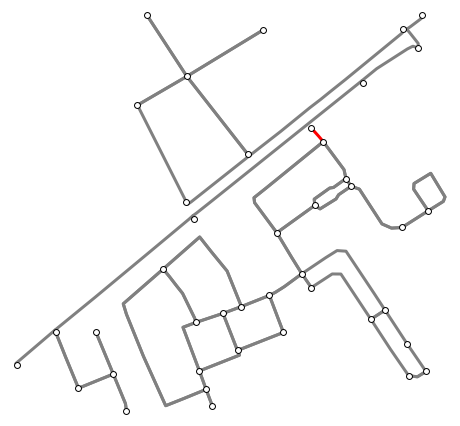

In [ ]:
# This may not work if there's more than one edge in the optimal solution
ec = ['r' if (u==30 and v==24) else 'grey' for u, v, k in G_design_ped.edges(keys=True)]
# ec_node = ['r' if (u==30 and v==24) else 'grey' for u, v, k in G_design_ped.edges(keys=True)]

# ['b' if (data['osmid']==25620516 or data['osmid']==25620570) else 'r' for node, data in G_map.nodes(data=True)]

fig, ax = ox.plot_graph(G_design_ped, bgcolor= 'w', node_color='w', node_edgecolor='k', node_size=35, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

#### 6.3 Scenario: median vulnerability vs. quantile vulnerability

In [ ]:
df

,vulnerability,accessibility
0,0.223,0.001384
1,0.195,0.001764
2,0.223,0.335078
3,0.195,0.014884
4,0.196,0.333906
5,0.214,0.002412
6,0.214,0.333400
7,0.195,0.008555
8,0.195,0.002743
9,0.196,0.012831


(array([ 1.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  4.,  7.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  9.]),
 array([0.159 , 0.1649, 0.1708, 0.1767, 0.1826, 0.1885, 0.1944, 0.2003,
        0.2062, 0.2121, 0.218 , 0.2239, 0.2298, 0.2357, 0.2416, 0.2475,
        0.2534, 0.2593, 0.2652, 0.2711, 0.277 ]),
 <BarContainer object of 20 artists>)

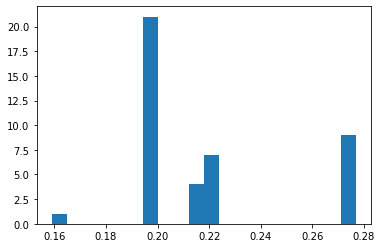

In [ ]:
plt.hist(df['vulnerability'], bins=20)

(array([12.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  5.,  5.,  7.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([-13.28771238, -12.70219841, -12.11668444, -11.53117047,
        -10.9456565 , -10.36014253,  -9.77462856,  -9.18911459,
         -8.60360062,  -8.01808665,  -7.43257268,  -6.84705871,
         -6.26154474,  -5.67603077,  -5.0905168 ,  -4.50500283,
         -3.91948886,  -3.33397489,  -2.74846092,  -2.16294695,
         -1.57743298]),
 <BarContainer object of 20 artists>)

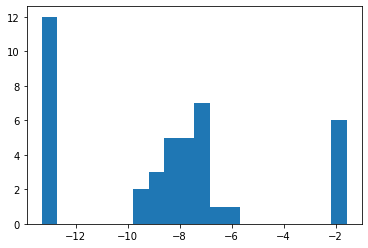

In [ ]:
plt.hist(np.log2(df['accessibility']), bins=20)

In [ ]:
x_median = df['vulnerability'].median() 
y_median = df['accessibility'].median()
y_median_log = np.log2(df['accessibility']).median()
x_avg = df['vulnerability'].mean()
y_avg_log = np.log2(df['accessibility']).mean()

In [ ]:
y_median_log

-8.178847668794868

In [ ]:
x_75_quantile = df.vulnerability.quantile(0.75)

In [ ]:
y_25_quantile_log = np.log2(df['accessibility']).quantile(0.25)
y_25_quantile_log

-13.287712379549449

In [ ]:
y_25_quantile = df.accessibility.quantile(0.25)

In [ ]:
y_25_quantile

0.0001

Text(0, 0.5, 'log(Accessibility)')

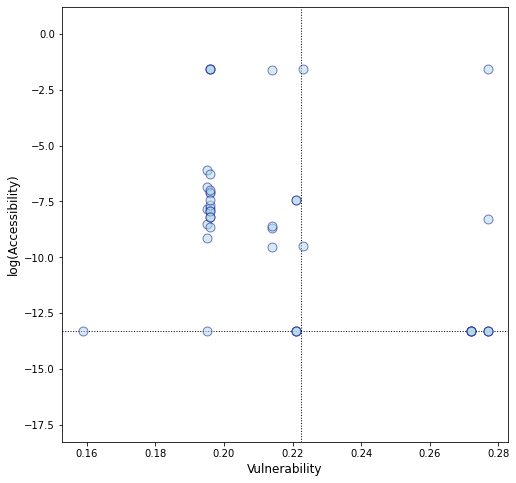

In [ ]:
csfont = {'fontname':'DejaVu Sans'}
fig, ax = plt.subplots(figsize=(8,8))
# plt.plot(df['vulnerability'],df['accessibility'],"o")
# plt.axhline(y=df['accessibility'].median(), color="black", linestyle="--")
# plt.axvline(x=df['vulnerability'].mean(), color="black", linestyle="--")
# plt.figure(figsize=(15,12))

ax.scatter(x=df['vulnerability'], y=np.log2(df['accessibility']), c='lightblue', edgecolor='darkblue', zorder=99, s=80, alpha=.5)
ax.axvline(x_75_quantile, c='k', linestyle = ":", lw=1)
ax.axhline(y_25_quantile_log, c='k', linestyle = ":", lw=1)

adj_x = max((df['vulnerability'].max() - x_avg), (x_avg - df['vulnerability'].min())) * 1.1
lb_x, ub_x = (x_avg - adj_x, x_avg + adj_x)
ax.set_xlim(lb_x, ub_x)

adj_y = max((df['accessibility'].max() - y_avg_log), (y_avg_log - df['accessibility'].min())) * 1.1
lb_y, ub_y = (y_avg_log - adj_y, y_avg_log + adj_y)
ax.set_ylim(lb_y, ub_y)
#ax.set_ylim(-0.05, ub_y)

# ax.set_xticks([(x_median - adj_x / 2), (x_median + adj_x / 2)])
# ax.set_xticklabels(['Low', 'High'])

#ax.set_title("Identifying vertices representing vulnerable\n spatial units with low accessibility\n", size=16, **csfont)
ax.set_xlabel("Vulnerability", size=12, **csfont)
ax.set_ylabel("log(Accessibility)",size=12, **csfont) # ax.set_ylabel("(In)accessibility")

#ax.text(0.16,6,"High ac",color="blue",size="6")
#ax.text(1,1,"Strong attack, strong defense",color="red",size="8")
# fig.savefig('./notebook_figures/a_vs_vul.eps',format='eps', dpi=1000,bbox_inches="tight")
# fig.savefig("./notebook_figures/a_vs_vul.png", format = 'png', dpi= 1000, bbox_inches="tight")

In [ ]:
# Get indices of highly vulnerable and inaccessible nodes (vul > vul_median & acc > acc_median)
v_indices = df.index[(df['vulnerability'] > x_75_quantile) & (df['accessibility'] <= y_25_quantile)].tolist() # have to use <= because otherwise nothing is below y_25_quantile 

# Get indices of nodes with low vulnerability (vul < vul_median)
v_bar_indices = df.index[(df['vulnerability'] < x_75_quantile)].tolist()

In [ ]:
v_indices

[30, 31, 32, 33, 34, 35, 40]

In [ ]:
v_bar_indices

[1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 26,
 27,
 28,
 29,
 36,
 37,
 38,
 39,
 41]